In [1]:
import sys
import numpy as np
sys.path.append("..")
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from models.attention_model1 import attentionmodel1
from utils.data_preprocessing import encode_sequences, MinMaxScaler3D, shuffle_array
from utils.parsers import parse_bulkiness, parse_hydrophobicity, parse_csv, load_kabat, aa_order, aa3_aa1
from utils.defines import VL_LENGTH, VH_LENGTH
import os

Using TensorFlow backend.
W0417 14:45:56.777525 139644935825216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:360: The name name_scope is deprecated. Please use compat.v1.name_scope instead.



In [2]:
class AminoAcidEncoder:
    def __init__(self, max_length, copy=True):
        """
        3D matrix scaling for RNN preparation with mask
        """
        self.copy = copy
        self.aa_order = list(map(lambda x: aa3_aa1[x], aa_order))
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result = np.zeros((len(X), self.max_length, len(aa_order)+1))
        for i in range(len(X)):
            for j in range(len(X[i])):
                try:
                    result[i, j, self.aa_order.index(X[i][j])] = 1
                except:
                    result[i, j, len(aa_order)] = 1
        return result

    def inverse_transform(self, X, y=None):
        result = list()
        for i in range(X.shape[0]):
            result_i=list()
            for j in range(self.max_length):
                idx = np.where(X[i,j]==1)[0]
                if idx.size != 0:
                    idx = int(idx)
                    if idx < len(self.aa_order):
                        result_i.append(self.aa_order[idx])
                    else:
                        result_i.append('')
            print(i, ''.join(result_i))
            result.append(''.join(result_i))
        return result

In [3]:
VL_sequences, VH_sequences, names_mask, animals_mask = \
    parse_csv(VH_LENGTH, VL_LENGTH,
              "../data/abysis_data_201801/abysis_data/emblig-20180125-7578.csv",
              "../data/abysis_data_201801/abysis_data/kabat-20180117-10288.csv")

VH_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_sequences)
VL_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_sequences)

VH_encoded_shuffled, VL_encoded_shuffled = shuffle_array(VH_encoded, VL_encoded)

In [4]:
encoder, autoencoder, sess = attentionmodel1(21, latent_dim=50, RNN_cell='LSTM')

W0417 14:46:03.811494 139644935825216 deprecation_wrapper.py:76] From ../models/attention_model1.py:25: The name ConfigProto is deprecated. Please use compat.v1.ConfigProto instead.

W0417 14:46:03.813043 139644935825216 deprecation_wrapper.py:76] From ../models/attention_model1.py:26: The name Session is deprecated. Please use compat.v1.Session instead.

W0417 14:46:04.036405 139644935825216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name placeholder is deprecated. Please use compat.v1.placeholder instead.

W0417 14:46:04.039369 139644935825216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name get_default_graph is deprecated. Please use compat.v1.get_default_graph instead.

W0417 14:46:05.109049 139644935825216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tra

Tensor("VL_output/add:0", shape=(?, 200, 21), dtype=float32) Tensor("VL_INPUT:0", shape=(?, 200, 21), dtype=float32)
Tensor("VH_output/add:0", shape=(?, 250, 21), dtype=float32) Tensor("VH_INPUT:0", shape=(?, 250, 21), dtype=float32)
[<tf.Tensor 'VL_attention_linear_output/add:0' shape=(?, 200, 21) dtype=float32>, <tf.Tensor 'VH_attention_linear_output/add:0' shape=(?, 250, 21) dtype=float32>]


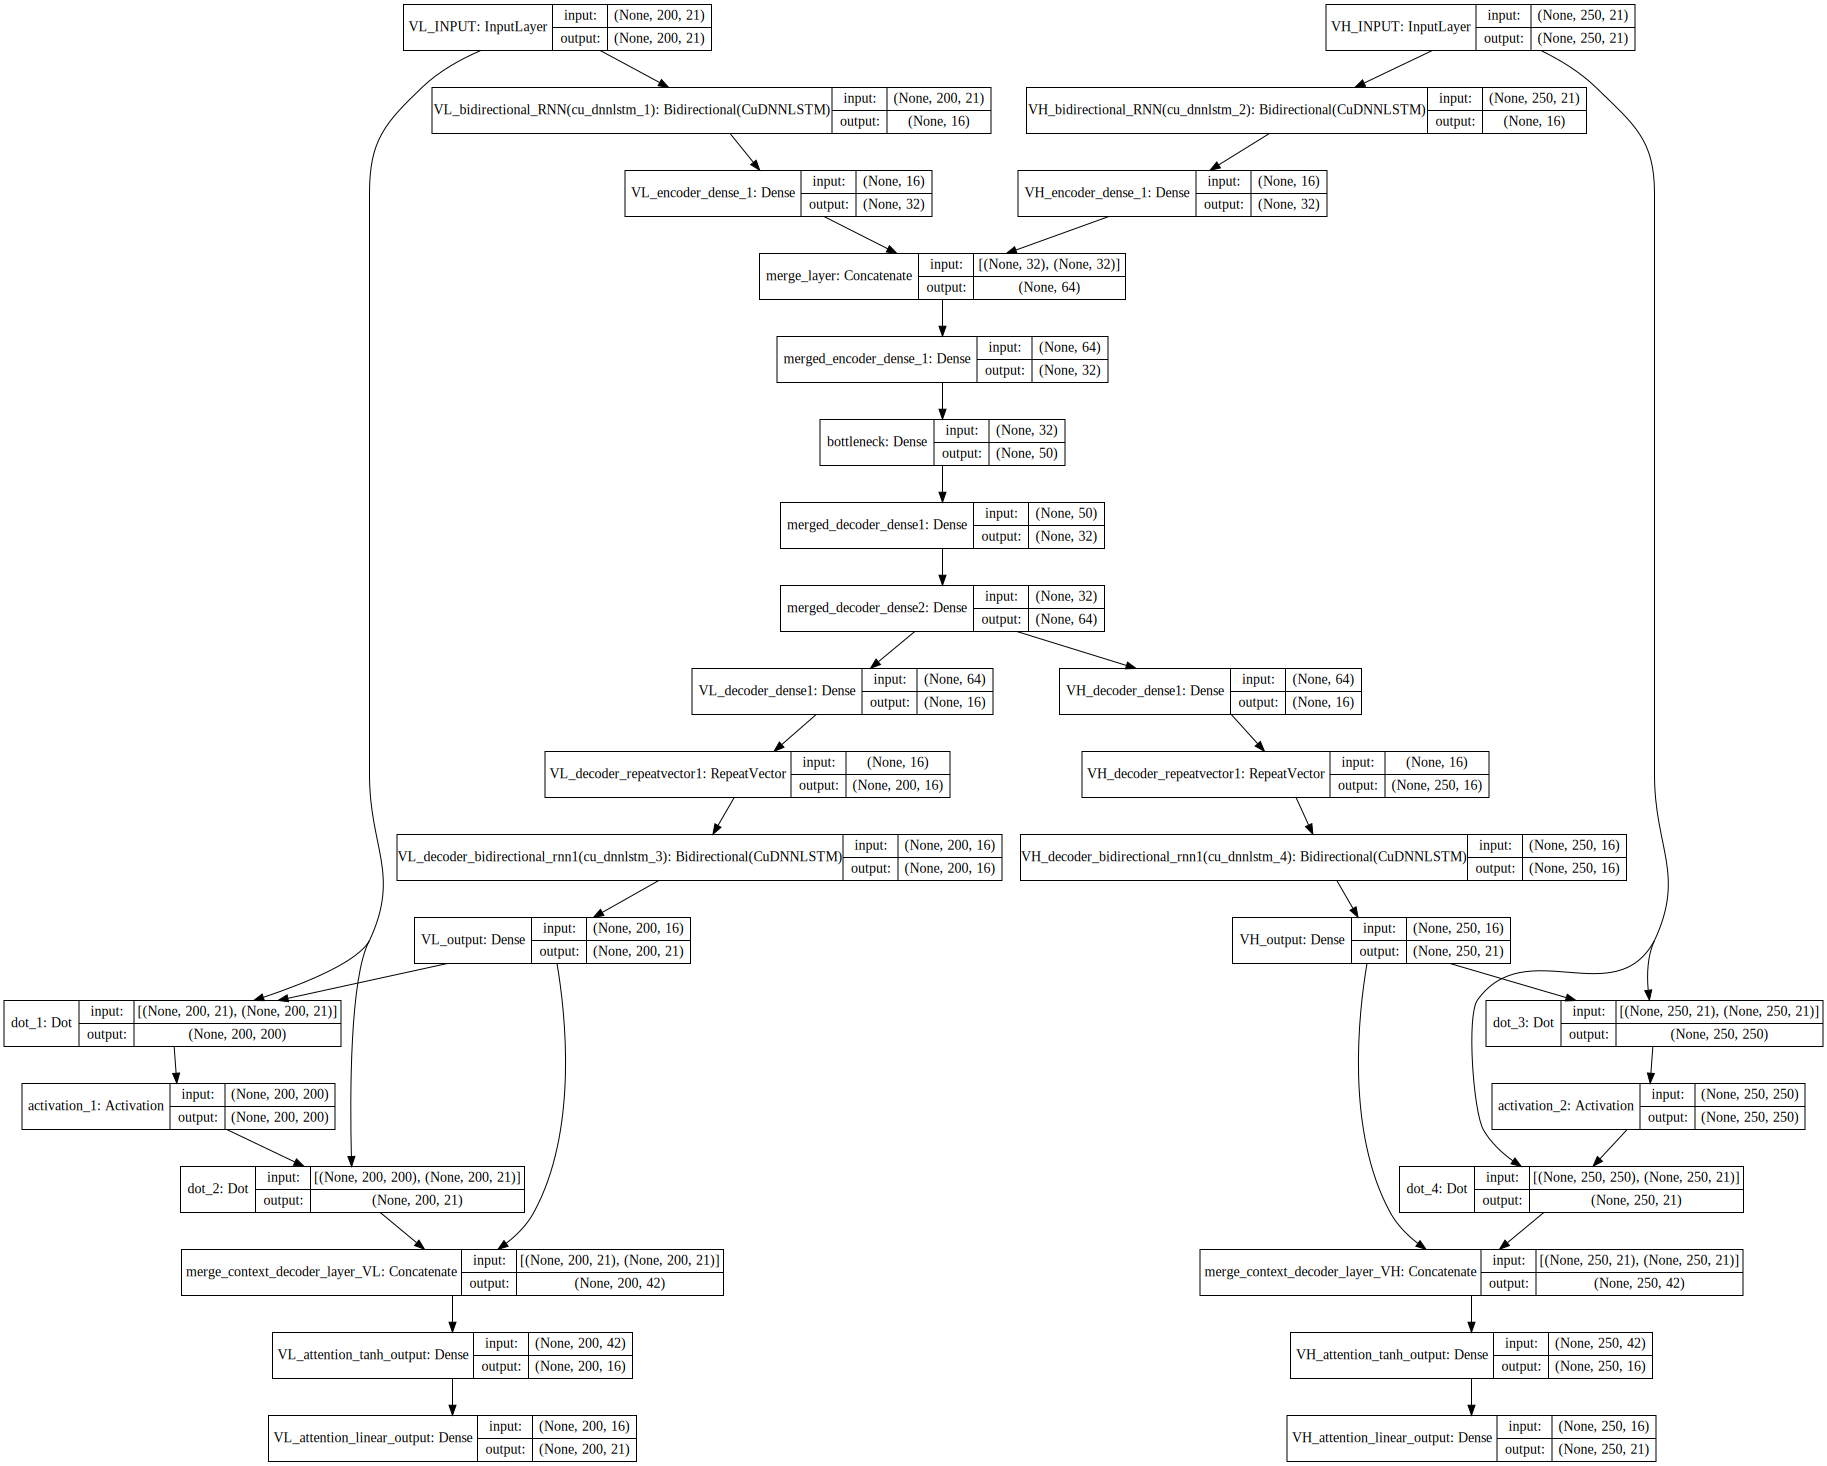

In [5]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VL_INPUT (InputLayer)           (None, 200, 21)      0                                            
__________________________________________________________________________________________________
VH_INPUT (InputLayer)           (None, 250, 21)      0                                            
__________________________________________________________________________________________________
VL_bidirectional_RNN (Bidirecti (None, 16)           4992        VL_INPUT[0][0]                   
__________________________________________________________________________________________________
VH_bidirectional_RNN (Bidirecti (None, 16)           4992        VH_INPUT[0][0]                   
__________________________________________________________________________________________________
VL_encoder

In [7]:
NAME= 'attention_autoencoder1_raw_lstm'
RUN = 'run1'

weight_path = '../model_weights/{}/{}/{}.hdf5'.format(NAME,RUN,NAME)
log_path = '../logs/{}/{}'.format(NAME, RUN)

In [8]:
if not os.path.exists('../model_weights/{}/{}/'.format(NAME,RUN)):
    if not os.path.exists('../model_weights/{}'.format(NAME)):
        os.mkdir('../model_weights/{}'.format(NAME))
    os.mkdir('../model_weights/{}/{}'.format(NAME,RUN))

In [9]:
from keras import backend as K

In [10]:
def get_loss(mask_value):

    """

    :param mask_value:
    :return:
    """

    mask_value = K.constant(mask_value, dtype=K.floatx())

    def masked_entropy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())
        mask_sum = K.sum(mask)
        l=K.tf.contrib.seq2seq.sequence_loss(targets=K.argmax(y_true), logits=y_pred, weights=mask,
                                     average_across_batch=False, average_across_timesteps=False)
        return K.sum(l) / mask_sum
    return masked_entropy
    
lhs=K.placeholder((None,200,21))
rhs=K.placeholder((None,200,21))

func=get_loss(0)(lhs, rhs)
r=sess.run(func, feed_dict={lhs: VL_encoded_shuffled[:1], rhs: VL_encoded_shuffled[:1]})

In [11]:
def acc(y_true, y_pred):
    mask = K.all(K.equal(y_true, 0), axis=-1)
    mask = 1 - K.cast(mask, K.floatx())
    mask_sum = K.sum(mask)
    acc = K.cast(K.equal(K.argmax(y_true), K.argmax(K.softmax(y_pred))), dtype=K.floatx()) * mask
    return K.sum(acc) / mask_sum

In [12]:
autoencoder.compile(optimizer=keras.optimizers.Adamax(), loss=get_loss(0), metrics=[acc])

In [13]:
class CosineAnnealingAdaptiveLRScheduler(keras.callbacks.Callback):

    """
    Keras adaptive learning scheduler implementation of cosine annealing
    that resets every cycle. A cycle unit is defined as the number of
    batches per epoch. The cycle can then be adjusted by a scalar after
    each cycle ending
    """

    def __init__(self, lr=None, cycle_len=1, cycle_mult=2):

        """
        CosineAnnealingAdaptiveLRScheduler constructor.
        Args:
            lr: base learning rate. If set to None it will be inferred from the model optimiser.
            cycle_len: initial cycle length. If set to 1 it will be equivalent to the number of batches per epoch
            cycle_mult: scalar to adjust cycle length at the end of each epoch
        """

        super(CosineAnnealingAdaptiveLRScheduler, self).__init__()

        self.lr = lr
        self.cycle_len = cycle_len
        self.cycle_mult = cycle_mult
        self.iteration = 0
        self.steps_per_epoch = None
        self.current_cycle_iterations = None

    def on_batch_begin(self, epoch, logs=None):

        """
        Callback to adjust the learning rate at the start of each batch
        Args:
            epoch:
            logs:
        Returns:
        """

        if self.current_cycle_iterations < self.iteration:
            # update cycle length
            self.cycle_len *= self.cycle_mult
            self.current_cycle_iterations = self._get_iter_per_cycle()
            # reset state to start new cycle
            self._reset()

        # cosine annealing -> the self.current_cycle_iterations+1 avoids cos(pi) which is 0
        new_lr = (np.cos(self.iteration / (self.current_cycle_iterations + 1) * np.pi) + 1) * self.lr

        K.set_value(self.model.optimizer.lr, new_lr)

#         print('\nIteration {}/{}: {}\n'.format(self.iteration, self.current_cycle_iterations, new_lr))

        self.iteration += 1

    def _get_iter_per_cycle(self):
        """
        Calculate the number of iterations in current cycle
        Returns:
        """
        return self.steps_per_epoch * self.cycle_len

    # adapted from https://github.com/uber/horovod/blob/master/horovod/keras/callbacks.py
    def on_train_begin(self, logs=None):
        """
        Sets some attributes that can only be inferred at model runtime.
        Args:
            logs:
        Returns:
        """
        if self.lr is None:
            self.lr = K.get_value(self.model.optimizer.lr)
        self.steps_per_epoch = self._autodetect_steps_per_epoch()
        self.current_cycle_iterations = self.steps_per_epoch * self.cycle_len

        # compensates for cosine annealing -> could divide by 2 at each step, or just do it here
        self.lr /= 2

    # https://github.com/uber/horovod/blob/master/horovod/keras/callbacks.py
    def _autodetect_steps_per_epoch(self):
        """
        Determine the number of steps per epoch.
        Returns:
        """
        if self.params.get('steps'):
            # The number of steps is provided in the parameters.
            return self.params['steps']
        elif self.params.get('samples') and self.params.get('batch_size'):
            # Compute the number of steps per epoch using # of samples and a batch size.
            return self.params['samples'] // self.params['batch_size']
        else:
            raise ValueError('Could not autodetect the number of steps per epoch. '
                             'Please specify the steps_per_epoch parameter to the '
                             '%s() or upgrade to the latest version of Keras.'
                             % self.__class__.__name__)

    def _reset(self):
        """
        Reset the state of the learning rate to start a new cycle.
        Returns:
        """
        self.iteration = 0

In [14]:
history = autoencoder.fit([VL_encoded_shuffled, VH_encoded_shuffled], [VL_encoded_shuffled, VH_encoded_shuffled],
                          epochs=5000, batch_size=32, validation_split=0.2,
                          callbacks=[CosineAnnealingAdaptiveLRScheduler(lr=0.01, cycle_len=2, cycle_mult=2),
                                     keras.callbacks.ModelCheckpoint(weight_path, save_best_only=True),
                                     keras.callbacks.TensorBoard(log_path)])

Train on 4144 samples, validate on 1036 samples


W0417 14:48:20.012768 139644935825216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name summary.merge_all is deprecated. Please use compat.v1.summary.merge_all instead.

W0417 14:48:20.013363 139644935825216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:853: The name summary.FileWriter is deprecated. Please use compat.v1.summary.FileWriter instead.



Epoch 1/5000
4144/4144 [==============================] - 12s 3ms/step - loss: 5.6098 - VL_attention_linear_output_loss: 2.7967 - VH_attention_linear_output_loss: 2.8131 - VL_attention_linear_output_acc: 0.1454 - VH_attention_linear_output_acc: 0.1304 - val_loss: 5.5145 - val_VL_attention_linear_output_loss: 2.7562 - val_VH_attention_linear_output_loss: 2.7583 - val_VL_attention_linear_output_acc: 0.1481 - val_VH_attention_linear_output_acc: 0.1388
Epoch 2/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 5.4739 - VL_attention_linear_output_loss: 2.7315 - VH_attention_linear_output_loss: 2.7424 - VL_attention_linear_output_acc: 0.1464 - VH_attention_linear_output_acc: 0.1397 - val_loss: 5.5724 - val_VL_attention_linear_output_loss: 2.8130 - val_VH_attention_linear_output_loss: 2.7594 - val_VL_attention_linear_output_acc: 0.1462 - val_VH_attention_linear_output_acc: 0.1357
Epoch 3/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 5.3905 - VL_atten

4144/4144 [==============================] - 9s 2ms/step - loss: 4.1392 - VL_attention_linear_output_loss: 2.0083 - VH_attention_linear_output_loss: 2.1309 - VL_attention_linear_output_acc: 0.3832 - VH_attention_linear_output_acc: 0.3304 - val_loss: 4.0979 - val_VL_attention_linear_output_loss: 1.9748 - val_VH_attention_linear_output_loss: 2.1231 - val_VL_attention_linear_output_acc: 0.3951 - val_VH_attention_linear_output_acc: 0.3417
Epoch 38/5000
4144/4144 [==============================] - 10s 2ms/step - loss: 4.1231 - VL_attention_linear_output_loss: 2.0007 - VH_attention_linear_output_loss: 2.1224 - VL_attention_linear_output_acc: 0.3836 - VH_attention_linear_output_acc: 0.3354 - val_loss: 4.3391 - val_VL_attention_linear_output_loss: 2.2154 - val_VH_attention_linear_output_loss: 2.1237 - val_VL_attention_linear_output_acc: 0.2794 - val_VH_attention_linear_output_acc: 0.3429
Epoch 39/5000
4144/4144 [==============================] - 10s 2ms/step - loss: 4.1313 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.9476 - VL_attention_linear_output_loss: 1.8968 - VH_attention_linear_output_loss: 2.0508 - VL_attention_linear_output_acc: 0.4285 - VH_attention_linear_output_acc: 0.3704 - val_loss: 4.1487 - val_VL_attention_linear_output_loss: 2.0560 - val_VH_attention_linear_output_loss: 2.0927 - val_VL_attention_linear_output_acc: 0.3394 - val_VH_attention_linear_output_acc: 0.3476
Epoch 74/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9835 - VL_attention_linear_output_loss: 1.9156 - VH_attention_linear_output_loss: 2.0679 - VL_attention_linear_output_acc: 0.4241 - VH_attention_linear_output_acc: 0.3632 - val_loss: 4.0035 - val_VL_attention_linear_output_loss: 1.9315 - val_VH_attention_linear_output_loss: 2.0720 - val_VL_attention_linear_output_acc: 0.4133 - val_VH_attention_linear_output_acc: 0.3590
Epoch 75/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9397 - VL_attention_linear_

Epoch 91/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8179 - VL_attention_linear_output_loss: 1.8297 - VH_attention_linear_output_loss: 1.9882 - VL_attention_linear_output_acc: 0.4601 - VH_attention_linear_output_acc: 0.3974 - val_loss: 3.8412 - val_VL_attention_linear_output_loss: 1.8181 - val_VH_attention_linear_output_loss: 2.0231 - val_VL_attention_linear_output_acc: 0.4623 - val_VH_attention_linear_output_acc: 0.3902
Epoch 92/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7908 - VL_attention_linear_output_loss: 1.7969 - VH_attention_linear_output_loss: 1.9939 - VL_attention_linear_output_acc: 0.4792 - VH_attention_linear_output_acc: 0.3956 - val_loss: 3.8642 - val_VL_attention_linear_output_loss: 1.8106 - val_VH_attention_linear_output_loss: 2.0536 - val_VL_attention_linear_output_acc: 0.4849 - val_VH_attention_linear_output_acc: 0.3740
Epoch 93/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7953 - VL_att

Epoch 109/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7060 - VL_attention_linear_output_loss: 1.7580 - VH_attention_linear_output_loss: 1.9480 - VL_attention_linear_output_acc: 0.4954 - VH_attention_linear_output_acc: 0.4162 - val_loss: 3.7624 - val_VL_attention_linear_output_loss: 1.7815 - val_VH_attention_linear_output_loss: 1.9809 - val_VL_attention_linear_output_acc: 0.4911 - val_VH_attention_linear_output_acc: 0.4083
Epoch 110/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7020 - VL_attention_linear_output_loss: 1.7560 - VH_attention_linear_output_loss: 1.9460 - VL_attention_linear_output_acc: 0.4964 - VH_attention_linear_output_acc: 0.4167 - val_loss: 3.7614 - val_VL_attention_linear_output_loss: 1.7815 - val_VH_attention_linear_output_loss: 1.9799 - val_VL_attention_linear_output_acc: 0.4851 - val_VH_attention_linear_output_acc: 0.4070
Epoch 111/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7007 - VL_

4144/4144 [==============================] - 9s 2ms/step - loss: 3.9328 - VL_attention_linear_output_loss: 1.9262 - VH_attention_linear_output_loss: 2.0066 - VL_attention_linear_output_acc: 0.4439 - VH_attention_linear_output_acc: 0.3895 - val_loss: 4.9586 - val_VL_attention_linear_output_loss: 2.8869 - val_VH_attention_linear_output_loss: 2.0717 - val_VL_attention_linear_output_acc: 0.2386 - val_VH_attention_linear_output_acc: 0.3757
Epoch 146/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9510 - VL_attention_linear_output_loss: 1.9108 - VH_attention_linear_output_loss: 2.0401 - VL_attention_linear_output_acc: 0.4410 - VH_attention_linear_output_acc: 0.3827 - val_loss: 3.8783 - val_VL_attention_linear_output_loss: 1.8354 - val_VH_attention_linear_output_loss: 2.0428 - val_VL_attention_linear_output_acc: 0.4511 - val_VH_attention_linear_output_acc: 0.3892
Epoch 147/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8319 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6482 - VL_attention_linear_output_loss: 1.7245 - VH_attention_linear_output_loss: 1.9237 - VL_attention_linear_output_acc: 0.5018 - VH_attention_linear_output_acc: 0.4148 - val_loss: 3.7941 - val_VL_attention_linear_output_loss: 1.8286 - val_VH_attention_linear_output_loss: 1.9655 - val_VL_attention_linear_output_acc: 0.4545 - val_VH_attention_linear_output_acc: 0.4047
Epoch 182/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6684 - VL_attention_linear_output_loss: 1.7475 - VH_attention_linear_output_loss: 1.9209 - VL_attention_linear_output_acc: 0.4884 - VH_attention_linear_output_acc: 0.4146 - val_loss: 3.6750 - val_VL_attention_linear_output_loss: 1.7354 - val_VH_attention_linear_output_loss: 1.9396 - val_VL_attention_linear_output_acc: 0.5027 - val_VH_attention_linear_output_acc: 0.4152
Epoch 183/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6358 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5305 - VL_attention_linear_output_loss: 1.6643 - VH_attention_linear_output_loss: 1.8662 - VL_attention_linear_output_acc: 0.5305 - VH_attention_linear_output_acc: 0.4395 - val_loss: 3.6145 - val_VL_attention_linear_output_loss: 1.7070 - val_VH_attention_linear_output_loss: 1.9075 - val_VL_attention_linear_output_acc: 0.5160 - val_VH_attention_linear_output_acc: 0.4304
Epoch 218/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5331 - VL_attention_linear_output_loss: 1.6638 - VH_attention_linear_output_loss: 1.8693 - VL_attention_linear_output_acc: 0.5295 - VH_attention_linear_output_acc: 0.4375 - val_loss: 3.6179 - val_VL_attention_linear_output_loss: 1.6938 - val_VH_attention_linear_output_loss: 1.9241 - val_VL_attention_linear_output_acc: 0.5198 - val_VH_attention_linear_output_acc: 0.4194
Epoch 219/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5306 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.9519 - VL_attention_linear_output_loss: 1.9291 - VH_attention_linear_output_loss: 2.0228 - VL_attention_linear_output_acc: 0.4199 - VH_attention_linear_output_acc: 0.3824 - val_loss: 3.8298 - val_VL_attention_linear_output_loss: 1.7773 - val_VH_attention_linear_output_loss: 2.0525 - val_VL_attention_linear_output_acc: 0.4860 - val_VH_attention_linear_output_acc: 0.3786
Epoch 254/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7393 - VL_attention_linear_output_loss: 1.7851 - VH_attention_linear_output_loss: 1.9542 - VL_attention_linear_output_acc: 0.4712 - VH_attention_linear_output_acc: 0.4131 - val_loss: 3.8989 - val_VL_attention_linear_output_loss: 1.9049 - val_VH_attention_linear_output_loss: 1.9940 - val_VL_attention_linear_output_acc: 0.4201 - val_VH_attention_linear_output_acc: 0.3945
Epoch 255/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7369 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6104 - VL_attention_linear_output_loss: 1.7046 - VH_attention_linear_output_loss: 1.9058 - VL_attention_linear_output_acc: 0.5080 - VH_attention_linear_output_acc: 0.4182 - val_loss: 3.6944 - val_VL_attention_linear_output_loss: 1.7569 - val_VH_attention_linear_output_loss: 1.9375 - val_VL_attention_linear_output_acc: 0.4813 - val_VH_attention_linear_output_acc: 0.4137
Epoch 290/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6673 - VL_attention_linear_output_loss: 1.7435 - VH_attention_linear_output_loss: 1.9238 - VL_attention_linear_output_acc: 0.4914 - VH_attention_linear_output_acc: 0.4117 - val_loss: 3.7088 - val_VL_attention_linear_output_loss: 1.7887 - val_VH_attention_linear_output_loss: 1.9201 - val_VL_attention_linear_output_acc: 0.4711 - val_VH_attention_linear_output_acc: 0.4184
Epoch 291/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5916 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5088 - VL_attention_linear_output_loss: 1.6406 - VH_attention_linear_output_loss: 1.8682 - VL_attention_linear_output_acc: 0.5360 - VH_attention_linear_output_acc: 0.4336 - val_loss: 3.6164 - val_VL_attention_linear_output_loss: 1.7063 - val_VH_attention_linear_output_loss: 1.9102 - val_VL_attention_linear_output_acc: 0.5158 - val_VH_attention_linear_output_acc: 0.4284
Epoch 326/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5369 - VL_attention_linear_output_loss: 1.6802 - VH_attention_linear_output_loss: 1.8567 - VL_attention_linear_output_acc: 0.5171 - VH_attention_linear_output_acc: 0.4383 - val_loss: 3.5912 - val_VL_attention_linear_output_loss: 1.6901 - val_VH_attention_linear_output_loss: 1.9012 - val_VL_attention_linear_output_acc: 0.5223 - val_VH_attention_linear_output_acc: 0.4312
Epoch 327/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4838 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4182 - VL_attention_linear_output_loss: 1.5988 - VH_attention_linear_output_loss: 1.8194 - VL_attention_linear_output_acc: 0.5484 - VH_attention_linear_output_acc: 0.4518 - val_loss: 3.4812 - val_VL_attention_linear_output_loss: 1.6196 - val_VH_attention_linear_output_loss: 1.8616 - val_VL_attention_linear_output_acc: 0.5384 - val_VH_attention_linear_output_acc: 0.4456
Epoch 362/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4231 - VL_attention_linear_output_loss: 1.6089 - VH_attention_linear_output_loss: 1.8141 - VL_attention_linear_output_acc: 0.5426 - VH_attention_linear_output_acc: 0.4541 - val_loss: 3.5047 - val_VL_attention_linear_output_loss: 1.6252 - val_VH_attention_linear_output_loss: 1.8795 - val_VL_attention_linear_output_acc: 0.5417 - val_VH_attention_linear_output_acc: 0.4387
Epoch 363/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4208 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3680 - VL_attention_linear_output_loss: 1.5703 - VH_attention_linear_output_loss: 1.7977 - VL_attention_linear_output_acc: 0.5590 - VH_attention_linear_output_acc: 0.4591 - val_loss: 3.4460 - val_VL_attention_linear_output_loss: 1.6030 - val_VH_attention_linear_output_loss: 1.8430 - val_VL_attention_linear_output_acc: 0.5524 - val_VH_attention_linear_output_acc: 0.4503
Epoch 398/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3601 - VL_attention_linear_output_loss: 1.5654 - VH_attention_linear_output_loss: 1.7947 - VL_attention_linear_output_acc: 0.5612 - VH_attention_linear_output_acc: 0.4602 - val_loss: 3.4708 - val_VL_attention_linear_output_loss: 1.6149 - val_VH_attention_linear_output_loss: 1.8559 - val_VL_attention_linear_output_acc: 0.5458 - val_VH_attention_linear_output_acc: 0.4471
Epoch 399/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3619 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2997 - VL_attention_linear_output_loss: 1.5345 - VH_attention_linear_output_loss: 1.7652 - VL_attention_linear_output_acc: 0.5724 - VH_attention_linear_output_acc: 0.4711 - val_loss: 3.4207 - val_VL_attention_linear_output_loss: 1.5901 - val_VH_attention_linear_output_loss: 1.8306 - val_VL_attention_linear_output_acc: 0.5574 - val_VH_attention_linear_output_acc: 0.4567
Epoch 434/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2964 - VL_attention_linear_output_loss: 1.5334 - VH_attention_linear_output_loss: 1.7630 - VL_attention_linear_output_acc: 0.5726 - VH_attention_linear_output_acc: 0.4720 - val_loss: 3.4365 - val_VL_attention_linear_output_loss: 1.6005 - val_VH_attention_linear_output_loss: 1.8360 - val_VL_attention_linear_output_acc: 0.5577 - val_VH_attention_linear_output_acc: 0.4559
Epoch 435/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3012 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2649 - VL_attention_linear_output_loss: 1.5178 - VH_attention_linear_output_loss: 1.7471 - VL_attention_linear_output_acc: 0.5779 - VH_attention_linear_output_acc: 0.4778 - val_loss: 3.4067 - val_VL_attention_linear_output_loss: 1.5796 - val_VH_attention_linear_output_loss: 1.8271 - val_VL_attention_linear_output_acc: 0.5621 - val_VH_attention_linear_output_acc: 0.4582
Epoch 470/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2653 - VL_attention_linear_output_loss: 1.5173 - VH_attention_linear_output_loss: 1.7480 - VL_attention_linear_output_acc: 0.5781 - VH_attention_linear_output_acc: 0.4774 - val_loss: 3.4117 - val_VL_attention_linear_output_loss: 1.5877 - val_VH_attention_linear_output_loss: 1.8240 - val_VL_attention_linear_output_acc: 0.5605 - val_VH_attention_linear_output_acc: 0.4592
Epoch 471/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2640 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2538 - VL_attention_linear_output_loss: 1.5117 - VH_attention_linear_output_loss: 1.7421 - VL_attention_linear_output_acc: 0.5799 - VH_attention_linear_output_acc: 0.4797 - val_loss: 3.4001 - val_VL_attention_linear_output_loss: 1.5771 - val_VH_attention_linear_output_loss: 1.8231 - val_VL_attention_linear_output_acc: 0.5626 - val_VH_attention_linear_output_acc: 0.4597
Epoch 506/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2550 - VL_attention_linear_output_loss: 1.5124 - VH_attention_linear_output_loss: 1.7426 - VL_attention_linear_output_acc: 0.5797 - VH_attention_linear_output_acc: 0.4795 - val_loss: 3.4001 - val_VL_attention_linear_output_loss: 1.5771 - val_VH_attention_linear_output_loss: 1.8231 - val_VL_attention_linear_output_acc: 0.5626 - val_VH_attention_linear_output_acc: 0.4598
Epoch 507/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6293 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4276 - VL_attention_linear_output_loss: 1.5886 - VH_attention_linear_output_loss: 1.8390 - VL_attention_linear_output_acc: 0.5498 - VH_attention_linear_output_acc: 0.4420 - val_loss: 3.4942 - val_VL_attention_linear_output_loss: 1.6027 - val_VH_attention_linear_output_loss: 1.8915 - val_VL_attention_linear_output_acc: 0.5560 - val_VH_attention_linear_output_acc: 0.4310
Epoch 542/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4042 - VL_attention_linear_output_loss: 1.5872 - VH_attention_linear_output_loss: 1.8170 - VL_attention_linear_output_acc: 0.5505 - VH_attention_linear_output_acc: 0.4490 - val_loss: 3.4949 - val_VL_attention_linear_output_loss: 1.6484 - val_VH_attention_linear_output_loss: 1.8464 - val_VL_attention_linear_output_acc: 0.5238 - val_VH_attention_linear_output_acc: 0.4473
Epoch 543/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4676 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3810 - VL_attention_linear_output_loss: 1.5771 - VH_attention_linear_output_loss: 1.8039 - VL_attention_linear_output_acc: 0.5523 - VH_attention_linear_output_acc: 0.4492 - val_loss: 3.4225 - val_VL_attention_linear_output_loss: 1.5941 - val_VH_attention_linear_output_loss: 1.8284 - val_VL_attention_linear_output_acc: 0.5512 - val_VH_attention_linear_output_acc: 0.4475
Epoch 578/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3723 - VL_attention_linear_output_loss: 1.5739 - VH_attention_linear_output_loss: 1.7984 - VL_attention_linear_output_acc: 0.5540 - VH_attention_linear_output_acc: 0.4500 - val_loss: 3.5458 - val_VL_attention_linear_output_loss: 1.7108 - val_VH_attention_linear_output_loss: 1.8350 - val_VL_attention_linear_output_acc: 0.4929 - val_VH_attention_linear_output_acc: 0.4457
Epoch 579/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4026 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3381 - VL_attention_linear_output_loss: 1.5791 - VH_attention_linear_output_loss: 1.7590 - VL_attention_linear_output_acc: 0.5591 - VH_attention_linear_output_acc: 0.4726 - val_loss: 3.5168 - val_VL_attention_linear_output_loss: 1.6249 - val_VH_attention_linear_output_loss: 1.8919 - val_VL_attention_linear_output_acc: 0.5471 - val_VH_attention_linear_output_acc: 0.4265
Epoch 614/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3629 - VL_attention_linear_output_loss: 1.5764 - VH_attention_linear_output_loss: 1.7865 - VL_attention_linear_output_acc: 0.5618 - VH_attention_linear_output_acc: 0.4622 - val_loss: 3.4058 - val_VL_attention_linear_output_loss: 1.5956 - val_VH_attention_linear_output_loss: 1.8102 - val_VL_attention_linear_output_acc: 0.5585 - val_VH_attention_linear_output_acc: 0.4639
Epoch 615/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3688 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2787 - VL_attention_linear_output_loss: 1.5360 - VH_attention_linear_output_loss: 1.7427 - VL_attention_linear_output_acc: 0.5747 - VH_attention_linear_output_acc: 0.4774 - val_loss: 3.3933 - val_VL_attention_linear_output_loss: 1.6031 - val_VH_attention_linear_output_loss: 1.7902 - val_VL_attention_linear_output_acc: 0.5504 - val_VH_attention_linear_output_acc: 0.4675
Epoch 650/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3741 - VL_attention_linear_output_loss: 1.5845 - VH_attention_linear_output_loss: 1.7896 - VL_attention_linear_output_acc: 0.5565 - VH_attention_linear_output_acc: 0.4670 - val_loss: 3.5186 - val_VL_attention_linear_output_loss: 1.6057 - val_VH_attention_linear_output_loss: 1.9129 - val_VL_attention_linear_output_acc: 0.5485 - val_VH_attention_linear_output_acc: 0.4499
Epoch 651/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3782 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2551 - VL_attention_linear_output_loss: 1.5096 - VH_attention_linear_output_loss: 1.7455 - VL_attention_linear_output_acc: 0.5800 - VH_attention_linear_output_acc: 0.4774 - val_loss: 3.3194 - val_VL_attention_linear_output_loss: 1.5443 - val_VH_attention_linear_output_loss: 1.7752 - val_VL_attention_linear_output_acc: 0.5678 - val_VH_attention_linear_output_acc: 0.4718
Epoch 686/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2502 - VL_attention_linear_output_loss: 1.5096 - VH_attention_linear_output_loss: 1.7406 - VL_attention_linear_output_acc: 0.5798 - VH_attention_linear_output_acc: 0.4793 - val_loss: 3.3333 - val_VL_attention_linear_output_loss: 1.5483 - val_VH_attention_linear_output_loss: 1.7850 - val_VL_attention_linear_output_acc: 0.5688 - val_VH_attention_linear_output_acc: 0.4678
Epoch 687/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2783 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1929 - VL_attention_linear_output_loss: 1.4880 - VH_attention_linear_output_loss: 1.7049 - VL_attention_linear_output_acc: 0.5879 - VH_attention_linear_output_acc: 0.4885 - val_loss: 3.3078 - val_VL_attention_linear_output_loss: 1.5429 - val_VH_attention_linear_output_loss: 1.7649 - val_VL_attention_linear_output_acc: 0.5706 - val_VH_attention_linear_output_acc: 0.4703
Epoch 722/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2037 - VL_attention_linear_output_loss: 1.4961 - VH_attention_linear_output_loss: 1.7075 - VL_attention_linear_output_acc: 0.5835 - VH_attention_linear_output_acc: 0.4874 - val_loss: 3.3313 - val_VL_attention_linear_output_loss: 1.5448 - val_VH_attention_linear_output_loss: 1.7865 - val_VL_attention_linear_output_acc: 0.5721 - val_VH_attention_linear_output_acc: 0.4663
Epoch 723/5000
4144/4144 [==============================] - 10s 2ms/step - loss: 3.2230 - VL_attention_line

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1366 - VL_attention_linear_output_loss: 1.4619 - VH_attention_linear_output_loss: 1.6746 - VL_attention_linear_output_acc: 0.5961 - VH_attention_linear_output_acc: 0.4973 - val_loss: 3.2434 - val_VL_attention_linear_output_loss: 1.5136 - val_VH_attention_linear_output_loss: 1.7298 - val_VL_attention_linear_output_acc: 0.5803 - val_VH_attention_linear_output_acc: 0.4839
Epoch 758/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1451 - VL_attention_linear_output_loss: 1.4591 - VH_attention_linear_output_loss: 1.6860 - VL_attention_linear_output_acc: 0.5978 - VH_attention_linear_output_acc: 0.4937 - val_loss: 3.2348 - val_VL_attention_linear_output_loss: 1.5001 - val_VH_attention_linear_output_loss: 1.7347 - val_VL_attention_linear_output_acc: 0.5867 - val_VH_attention_linear_output_acc: 0.4793
Epoch 759/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1375 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0895 - VL_attention_linear_output_loss: 1.4354 - VH_attention_linear_output_loss: 1.6541 - VL_attention_linear_output_acc: 0.6045 - VH_attention_linear_output_acc: 0.5038 - val_loss: 3.2370 - val_VL_attention_linear_output_loss: 1.4938 - val_VH_attention_linear_output_loss: 1.7432 - val_VL_attention_linear_output_acc: 0.5883 - val_VH_attention_linear_output_acc: 0.4737
Epoch 794/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0856 - VL_attention_linear_output_loss: 1.4348 - VH_attention_linear_output_loss: 1.6508 - VL_attention_linear_output_acc: 0.6044 - VH_attention_linear_output_acc: 0.5048 - val_loss: 3.2355 - val_VL_attention_linear_output_loss: 1.5158 - val_VH_attention_linear_output_loss: 1.7197 - val_VL_attention_linear_output_acc: 0.5825 - val_VH_attention_linear_output_acc: 0.4872
Epoch 795/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0978 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0609 - VL_attention_linear_output_loss: 1.4276 - VH_attention_linear_output_loss: 1.6333 - VL_attention_linear_output_acc: 0.6050 - VH_attention_linear_output_acc: 0.5110 - val_loss: 3.2076 - val_VL_attention_linear_output_loss: 1.4920 - val_VH_attention_linear_output_loss: 1.7156 - val_VL_attention_linear_output_acc: 0.5911 - val_VH_attention_linear_output_acc: 0.4885
Epoch 830/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0727 - VL_attention_linear_output_loss: 1.4351 - VH_attention_linear_output_loss: 1.6376 - VL_attention_linear_output_acc: 0.6038 - VH_attention_linear_output_acc: 0.5093 - val_loss: 3.2208 - val_VL_attention_linear_output_loss: 1.5027 - val_VH_attention_linear_output_loss: 1.7182 - val_VL_attention_linear_output_acc: 0.5867 - val_VH_attention_linear_output_acc: 0.4872
Epoch 831/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0646 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0360 - VL_attention_linear_output_loss: 1.4139 - VH_attention_linear_output_loss: 1.6221 - VL_attention_linear_output_acc: 0.6107 - VH_attention_linear_output_acc: 0.5145 - val_loss: 3.2193 - val_VL_attention_linear_output_loss: 1.5067 - val_VH_attention_linear_output_loss: 1.7126 - val_VL_attention_linear_output_acc: 0.5867 - val_VH_attention_linear_output_acc: 0.4904
Epoch 866/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0320 - VL_attention_linear_output_loss: 1.4129 - VH_attention_linear_output_loss: 1.6190 - VL_attention_linear_output_acc: 0.6113 - VH_attention_linear_output_acc: 0.5155 - val_loss: 3.2051 - val_VL_attention_linear_output_loss: 1.5001 - val_VH_attention_linear_output_loss: 1.7050 - val_VL_attention_linear_output_acc: 0.5898 - val_VH_attention_linear_output_acc: 0.4925
Epoch 867/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0269 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0105 - VL_attention_linear_output_loss: 1.3988 - VH_attention_linear_output_loss: 1.6117 - VL_attention_linear_output_acc: 0.6153 - VH_attention_linear_output_acc: 0.5166 - val_loss: 3.1942 - val_VL_attention_linear_output_loss: 1.4917 - val_VH_attention_linear_output_loss: 1.7025 - val_VL_attention_linear_output_acc: 0.5919 - val_VH_attention_linear_output_acc: 0.4937
Epoch 902/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0063 - VL_attention_linear_output_loss: 1.3974 - VH_attention_linear_output_loss: 1.6089 - VL_attention_linear_output_acc: 0.6159 - VH_attention_linear_output_acc: 0.5176 - val_loss: 3.1879 - val_VL_attention_linear_output_loss: 1.4856 - val_VH_attention_linear_output_loss: 1.7023 - val_VL_attention_linear_output_acc: 0.5943 - val_VH_attention_linear_output_acc: 0.4943
Epoch 903/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0093 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9905 - VL_attention_linear_output_loss: 1.3879 - VH_attention_linear_output_loss: 1.6026 - VL_attention_linear_output_acc: 0.6188 - VH_attention_linear_output_acc: 0.5196 - val_loss: 3.1881 - val_VL_attention_linear_output_loss: 1.4845 - val_VH_attention_linear_output_loss: 1.7037 - val_VL_attention_linear_output_acc: 0.5964 - val_VH_attention_linear_output_acc: 0.4949
Epoch 938/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9893 - VL_attention_linear_output_loss: 1.3887 - VH_attention_linear_output_loss: 1.6006 - VL_attention_linear_output_acc: 0.6191 - VH_attention_linear_output_acc: 0.5201 - val_loss: 3.1850 - val_VL_attention_linear_output_loss: 1.4842 - val_VH_attention_linear_output_loss: 1.7007 - val_VL_attention_linear_output_acc: 0.5962 - val_VH_attention_linear_output_acc: 0.4948
Epoch 939/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9897 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9803 - VL_attention_linear_output_loss: 1.3837 - VH_attention_linear_output_loss: 1.5967 - VL_attention_linear_output_acc: 0.6200 - VH_attention_linear_output_acc: 0.5213 - val_loss: 3.1848 - val_VL_attention_linear_output_loss: 1.4847 - val_VH_attention_linear_output_loss: 1.7000 - val_VL_attention_linear_output_acc: 0.5959 - val_VH_attention_linear_output_acc: 0.4964
Epoch 974/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9805 - VL_attention_linear_output_loss: 1.3838 - VH_attention_linear_output_loss: 1.5966 - VL_attention_linear_output_acc: 0.6202 - VH_attention_linear_output_acc: 0.5214 - val_loss: 3.1856 - val_VL_attention_linear_output_loss: 1.4858 - val_VH_attention_linear_output_loss: 1.6998 - val_VL_attention_linear_output_acc: 0.5947 - val_VH_attention_linear_output_acc: 0.4961
Epoch 975/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9798 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9773 - VL_attention_linear_output_loss: 1.3824 - VH_attention_linear_output_loss: 1.5950 - VL_attention_linear_output_acc: 0.6205 - VH_attention_linear_output_acc: 0.5220 - val_loss: 3.1844 - val_VL_attention_linear_output_loss: 1.4842 - val_VH_attention_linear_output_loss: 1.7002 - val_VL_attention_linear_output_acc: 0.5958 - val_VH_attention_linear_output_acc: 0.4963
Epoch 1010/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9766 - VL_attention_linear_output_loss: 1.3819 - VH_attention_linear_output_loss: 1.5947 - VL_attention_linear_output_acc: 0.6206 - VH_attention_linear_output_acc: 0.5220 - val_loss: 3.1846 - val_VL_attention_linear_output_loss: 1.4843 - val_VH_attention_linear_output_loss: 1.7002 - val_VL_attention_linear_output_acc: 0.5958 - val_VH_attention_linear_output_acc: 0.4963
Epoch 1011/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9763 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2440 - VL_attention_linear_output_loss: 1.5239 - VH_attention_linear_output_loss: 1.7201 - VL_attention_linear_output_acc: 0.5726 - VH_attention_linear_output_acc: 0.4791 - val_loss: 3.2839 - val_VL_attention_linear_output_loss: 1.5443 - val_VH_attention_linear_output_loss: 1.7397 - val_VL_attention_linear_output_acc: 0.5770 - val_VH_attention_linear_output_acc: 0.4793
Epoch 1046/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3437 - VL_attention_linear_output_loss: 1.5932 - VH_attention_linear_output_loss: 1.7505 - VL_attention_linear_output_acc: 0.5522 - VH_attention_linear_output_acc: 0.4763 - val_loss: 3.3400 - val_VL_attention_linear_output_loss: 1.5524 - val_VH_attention_linear_output_loss: 1.7876 - val_VL_attention_linear_output_acc: 0.5747 - val_VH_attention_linear_output_acc: 0.4678
Epoch 1047/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2910 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2350 - VL_attention_linear_output_loss: 1.5125 - VH_attention_linear_output_loss: 1.7225 - VL_attention_linear_output_acc: 0.5795 - VH_attention_linear_output_acc: 0.4785 - val_loss: 3.3043 - val_VL_attention_linear_output_loss: 1.5421 - val_VH_attention_linear_output_loss: 1.7622 - val_VL_attention_linear_output_acc: 0.5760 - val_VH_attention_linear_output_acc: 0.4729
Epoch 1082/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3181 - VL_attention_linear_output_loss: 1.5868 - VH_attention_linear_output_loss: 1.7313 - VL_attention_linear_output_acc: 0.5524 - VH_attention_linear_output_acc: 0.4763 - val_loss: 3.3329 - val_VL_attention_linear_output_loss: 1.5713 - val_VH_attention_linear_output_loss: 1.7616 - val_VL_attention_linear_output_acc: 0.5610 - val_VH_attention_linear_output_acc: 0.4723
Epoch 1083/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2250 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1722 - VL_attention_linear_output_loss: 1.4960 - VH_attention_linear_output_loss: 1.6762 - VL_attention_linear_output_acc: 0.5829 - VH_attention_linear_output_acc: 0.4940 - val_loss: 3.2778 - val_VL_attention_linear_output_loss: 1.5633 - val_VH_attention_linear_output_loss: 1.7145 - val_VL_attention_linear_output_acc: 0.5636 - val_VH_attention_linear_output_acc: 0.4857
Epoch 1118/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2319 - VL_attention_linear_output_loss: 1.5499 - VH_attention_linear_output_loss: 1.6820 - VL_attention_linear_output_acc: 0.5660 - VH_attention_linear_output_acc: 0.4914 - val_loss: 3.3276 - val_VL_attention_linear_output_loss: 1.5954 - val_VH_attention_linear_output_loss: 1.7321 - val_VL_attention_linear_output_acc: 0.5507 - val_VH_attention_linear_output_acc: 0.4833
Epoch 1119/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1297 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1378 - VL_attention_linear_output_loss: 1.4626 - VH_attention_linear_output_loss: 1.6752 - VL_attention_linear_output_acc: 0.5978 - VH_attention_linear_output_acc: 0.4968 - val_loss: 3.3133 - val_VL_attention_linear_output_loss: 1.4881 - val_VH_attention_linear_output_loss: 1.8252 - val_VL_attention_linear_output_acc: 0.5945 - val_VH_attention_linear_output_acc: 0.4363
Epoch 1154/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1609 - VL_attention_linear_output_loss: 1.5044 - VH_attention_linear_output_loss: 1.6565 - VL_attention_linear_output_acc: 0.5823 - VH_attention_linear_output_acc: 0.4996 - val_loss: 3.2158 - val_VL_attention_linear_output_loss: 1.5069 - val_VH_attention_linear_output_loss: 1.7089 - val_VL_attention_linear_output_acc: 0.5883 - val_VH_attention_linear_output_acc: 0.4878
Epoch 1155/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1631 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1496 - VL_attention_linear_output_loss: 1.4742 - VH_attention_linear_output_loss: 1.6754 - VL_attention_linear_output_acc: 0.5927 - VH_attention_linear_output_acc: 0.4979 - val_loss: 3.2605 - val_VL_attention_linear_output_loss: 1.4823 - val_VH_attention_linear_output_loss: 1.7781 - val_VL_attention_linear_output_acc: 0.5969 - val_VH_attention_linear_output_acc: 0.4714
Epoch 1190/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1503 - VL_attention_linear_output_loss: 1.4828 - VH_attention_linear_output_loss: 1.6676 - VL_attention_linear_output_acc: 0.5910 - VH_attention_linear_output_acc: 0.5016 - val_loss: 3.4699 - val_VL_attention_linear_output_loss: 1.6767 - val_VH_attention_linear_output_loss: 1.7932 - val_VL_attention_linear_output_acc: 0.5317 - val_VH_attention_linear_output_acc: 0.4703
Epoch 1191/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1580 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1028 - VL_attention_linear_output_loss: 1.4437 - VH_attention_linear_output_loss: 1.6591 - VL_attention_linear_output_acc: 0.6058 - VH_attention_linear_output_acc: 0.5127 - val_loss: 3.2555 - val_VL_attention_linear_output_loss: 1.5036 - val_VH_attention_linear_output_loss: 1.7519 - val_VL_attention_linear_output_acc: 0.5941 - val_VH_attention_linear_output_acc: 0.4902
Epoch 1226/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1212 - VL_attention_linear_output_loss: 1.4324 - VH_attention_linear_output_loss: 1.6888 - VL_attention_linear_output_acc: 0.6093 - VH_attention_linear_output_acc: 0.5021 - val_loss: 3.3129 - val_VL_attention_linear_output_loss: 1.5348 - val_VH_attention_linear_output_loss: 1.7781 - val_VL_attention_linear_output_acc: 0.5839 - val_VH_attention_linear_output_acc: 0.4780
Epoch 1227/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1363 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0446 - VL_attention_linear_output_loss: 1.4200 - VH_attention_linear_output_loss: 1.6246 - VL_attention_linear_output_acc: 0.6160 - VH_attention_linear_output_acc: 0.5161 - val_loss: 3.1846 - val_VL_attention_linear_output_loss: 1.5151 - val_VH_attention_linear_output_loss: 1.6695 - val_VL_attention_linear_output_acc: 0.5853 - val_VH_attention_linear_output_acc: 0.5040
Epoch 1262/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0830 - VL_attention_linear_output_loss: 1.4280 - VH_attention_linear_output_loss: 1.6550 - VL_attention_linear_output_acc: 0.6135 - VH_attention_linear_output_acc: 0.5060 - val_loss: 3.1698 - val_VL_attention_linear_output_loss: 1.4659 - val_VH_attention_linear_output_loss: 1.7039 - val_VL_attention_linear_output_acc: 0.6057 - val_VH_attention_linear_output_acc: 0.4983
Epoch 1263/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0486 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0085 - VL_attention_linear_output_loss: 1.4153 - VH_attention_linear_output_loss: 1.5933 - VL_attention_linear_output_acc: 0.6205 - VH_attention_linear_output_acc: 0.5263 - val_loss: 3.1524 - val_VL_attention_linear_output_loss: 1.4723 - val_VH_attention_linear_output_loss: 1.6801 - val_VL_attention_linear_output_acc: 0.6081 - val_VH_attention_linear_output_acc: 0.5062
Epoch 1298/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0263 - VL_attention_linear_output_loss: 1.4203 - VH_attention_linear_output_loss: 1.6061 - VL_attention_linear_output_acc: 0.6173 - VH_attention_linear_output_acc: 0.5207 - val_loss: 3.1917 - val_VL_attention_linear_output_loss: 1.5258 - val_VH_attention_linear_output_loss: 1.6658 - val_VL_attention_linear_output_acc: 0.5842 - val_VH_attention_linear_output_acc: 0.5082
Epoch 1299/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0151 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9590 - VL_attention_linear_output_loss: 1.3801 - VH_attention_linear_output_loss: 1.5789 - VL_attention_linear_output_acc: 0.6357 - VH_attention_linear_output_acc: 0.5306 - val_loss: 3.1042 - val_VL_attention_linear_output_loss: 1.4591 - val_VH_attention_linear_output_loss: 1.6451 - val_VL_attention_linear_output_acc: 0.6142 - val_VH_attention_linear_output_acc: 0.5152
Epoch 1334/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0008 - VL_attention_linear_output_loss: 1.3835 - VH_attention_linear_output_loss: 1.6173 - VL_attention_linear_output_acc: 0.6353 - VH_attention_linear_output_acc: 0.5187 - val_loss: 3.2450 - val_VL_attention_linear_output_loss: 1.4511 - val_VH_attention_linear_output_loss: 1.7939 - val_VL_attention_linear_output_acc: 0.6196 - val_VH_attention_linear_output_acc: 0.4802
Epoch 1335/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0568 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9976 - VL_attention_linear_output_loss: 1.3993 - VH_attention_linear_output_loss: 1.5983 - VL_attention_linear_output_acc: 0.6296 - VH_attention_linear_output_acc: 0.5301 - val_loss: 3.0972 - val_VL_attention_linear_output_loss: 1.4519 - val_VH_attention_linear_output_loss: 1.6453 - val_VL_attention_linear_output_acc: 0.6191 - val_VH_attention_linear_output_acc: 0.5197
Epoch 1370/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9706 - VL_attention_linear_output_loss: 1.3839 - VH_attention_linear_output_loss: 1.5867 - VL_attention_linear_output_acc: 0.6347 - VH_attention_linear_output_acc: 0.5311 - val_loss: 3.1097 - val_VL_attention_linear_output_loss: 1.4488 - val_VH_attention_linear_output_loss: 1.6610 - val_VL_attention_linear_output_acc: 0.6200 - val_VH_attention_linear_output_acc: 0.5133
Epoch 1371/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9465 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8863 - VL_attention_linear_output_loss: 1.3420 - VH_attention_linear_output_loss: 1.5442 - VL_attention_linear_output_acc: 0.6457 - VH_attention_linear_output_acc: 0.5447 - val_loss: 3.0587 - val_VL_attention_linear_output_loss: 1.4228 - val_VH_attention_linear_output_loss: 1.6359 - val_VL_attention_linear_output_acc: 0.6291 - val_VH_attention_linear_output_acc: 0.5261
Epoch 1406/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8936 - VL_attention_linear_output_loss: 1.3490 - VH_attention_linear_output_loss: 1.5445 - VL_attention_linear_output_acc: 0.6426 - VH_attention_linear_output_acc: 0.5450 - val_loss: 3.0724 - val_VL_attention_linear_output_loss: 1.4407 - val_VH_attention_linear_output_loss: 1.6316 - val_VL_attention_linear_output_acc: 0.6215 - val_VH_attention_linear_output_acc: 0.5255
Epoch 1407/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9008 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9123 - VL_attention_linear_output_loss: 1.3484 - VH_attention_linear_output_loss: 1.5639 - VL_attention_linear_output_acc: 0.6427 - VH_attention_linear_output_acc: 0.5414 - val_loss: 3.0520 - val_VL_attention_linear_output_loss: 1.4198 - val_VH_attention_linear_output_loss: 1.6322 - val_VL_attention_linear_output_acc: 0.6274 - val_VH_attention_linear_output_acc: 0.5311
Epoch 1442/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9333 - VL_attention_linear_output_loss: 1.3708 - VH_attention_linear_output_loss: 1.5625 - VL_attention_linear_output_acc: 0.6353 - VH_attention_linear_output_acc: 0.5433 - val_loss: 3.0988 - val_VL_attention_linear_output_loss: 1.4407 - val_VH_attention_linear_output_loss: 1.6581 - val_VL_attention_linear_output_acc: 0.6215 - val_VH_attention_linear_output_acc: 0.5193
Epoch 1443/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9038 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9030 - VL_attention_linear_output_loss: 1.3599 - VH_attention_linear_output_loss: 1.5431 - VL_attention_linear_output_acc: 0.6372 - VH_attention_linear_output_acc: 0.5480 - val_loss: 3.0650 - val_VL_attention_linear_output_loss: 1.4458 - val_VH_attention_linear_output_loss: 1.6192 - val_VL_attention_linear_output_acc: 0.6208 - val_VH_attention_linear_output_acc: 0.5320
Epoch 1478/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8638 - VL_attention_linear_output_loss: 1.3377 - VH_attention_linear_output_loss: 1.5260 - VL_attention_linear_output_acc: 0.6458 - VH_attention_linear_output_acc: 0.5520 - val_loss: 3.0211 - val_VL_attention_linear_output_loss: 1.4070 - val_VH_attention_linear_output_loss: 1.6142 - val_VL_attention_linear_output_acc: 0.6318 - val_VH_attention_linear_output_acc: 0.5351
Epoch 1479/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8621 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8209 - VL_attention_linear_output_loss: 1.3165 - VH_attention_linear_output_loss: 1.5044 - VL_attention_linear_output_acc: 0.6509 - VH_attention_linear_output_acc: 0.5601 - val_loss: 3.1210 - val_VL_attention_linear_output_loss: 1.4643 - val_VH_attention_linear_output_loss: 1.6567 - val_VL_attention_linear_output_acc: 0.6108 - val_VH_attention_linear_output_acc: 0.5179
Epoch 1514/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8291 - VL_attention_linear_output_loss: 1.3236 - VH_attention_linear_output_loss: 1.5054 - VL_attention_linear_output_acc: 0.6479 - VH_attention_linear_output_acc: 0.5590 - val_loss: 3.0154 - val_VL_attention_linear_output_loss: 1.4035 - val_VH_attention_linear_output_loss: 1.6118 - val_VL_attention_linear_output_acc: 0.6324 - val_VH_attention_linear_output_acc: 0.5366
Epoch 1515/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8244 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7998 - VL_attention_linear_output_loss: 1.3019 - VH_attention_linear_output_loss: 1.4979 - VL_attention_linear_output_acc: 0.6562 - VH_attention_linear_output_acc: 0.5628 - val_loss: 3.0339 - val_VL_attention_linear_output_loss: 1.4083 - val_VH_attention_linear_output_loss: 1.6256 - val_VL_attention_linear_output_acc: 0.6327 - val_VH_attention_linear_output_acc: 0.5360
Epoch 1550/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7982 - VL_attention_linear_output_loss: 1.2963 - VH_attention_linear_output_loss: 1.5019 - VL_attention_linear_output_acc: 0.6583 - VH_attention_linear_output_acc: 0.5613 - val_loss: 3.0733 - val_VL_attention_linear_output_loss: 1.4049 - val_VH_attention_linear_output_loss: 1.6684 - val_VL_attention_linear_output_acc: 0.6354 - val_VH_attention_linear_output_acc: 0.5169
Epoch 1551/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8190 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7699 - VL_attention_linear_output_loss: 1.2911 - VH_attention_linear_output_loss: 1.4788 - VL_attention_linear_output_acc: 0.6603 - VH_attention_linear_output_acc: 0.5698 - val_loss: 3.0133 - val_VL_attention_linear_output_loss: 1.4054 - val_VH_attention_linear_output_loss: 1.6079 - val_VL_attention_linear_output_acc: 0.6365 - val_VH_attention_linear_output_acc: 0.5420
Epoch 1586/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7694 - VL_attention_linear_output_loss: 1.2909 - VH_attention_linear_output_loss: 1.4785 - VL_attention_linear_output_acc: 0.6598 - VH_attention_linear_output_acc: 0.5694 - val_loss: 3.0493 - val_VL_attention_linear_output_loss: 1.4139 - val_VH_attention_linear_output_loss: 1.6354 - val_VL_attention_linear_output_acc: 0.6347 - val_VH_attention_linear_output_acc: 0.5324
Epoch 1587/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8098 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7501 - VL_attention_linear_output_loss: 1.2825 - VH_attention_linear_output_loss: 1.4676 - VL_attention_linear_output_acc: 0.6616 - VH_attention_linear_output_acc: 0.5735 - val_loss: 3.0184 - val_VL_attention_linear_output_loss: 1.3994 - val_VH_attention_linear_output_loss: 1.6190 - val_VL_attention_linear_output_acc: 0.6387 - val_VH_attention_linear_output_acc: 0.5408
Epoch 1622/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7490 - VL_attention_linear_output_loss: 1.2818 - VH_attention_linear_output_loss: 1.4672 - VL_attention_linear_output_acc: 0.6625 - VH_attention_linear_output_acc: 0.5739 - val_loss: 3.0069 - val_VL_attention_linear_output_loss: 1.3998 - val_VH_attention_linear_output_loss: 1.6071 - val_VL_attention_linear_output_acc: 0.6368 - val_VH_attention_linear_output_acc: 0.5450
Epoch 1623/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7547 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7229 - VL_attention_linear_output_loss: 1.2718 - VH_attention_linear_output_loss: 1.4511 - VL_attention_linear_output_acc: 0.6651 - VH_attention_linear_output_acc: 0.5801 - val_loss: 3.0022 - val_VL_attention_linear_output_loss: 1.3887 - val_VH_attention_linear_output_loss: 1.6135 - val_VL_attention_linear_output_acc: 0.6416 - val_VH_attention_linear_output_acc: 0.5452
Epoch 1658/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7218 - VL_attention_linear_output_loss: 1.2702 - VH_attention_linear_output_loss: 1.4516 - VL_attention_linear_output_acc: 0.6664 - VH_attention_linear_output_acc: 0.5795 - val_loss: 3.0036 - val_VL_attention_linear_output_loss: 1.3886 - val_VH_attention_linear_output_loss: 1.6149 - val_VL_attention_linear_output_acc: 0.6426 - val_VH_attention_linear_output_acc: 0.5418
Epoch 1659/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7277 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7135 - VL_attention_linear_output_loss: 1.2675 - VH_attention_linear_output_loss: 1.4460 - VL_attention_linear_output_acc: 0.6672 - VH_attention_linear_output_acc: 0.5816 - val_loss: 3.0146 - val_VL_attention_linear_output_loss: 1.4007 - val_VH_attention_linear_output_loss: 1.6139 - val_VL_attention_linear_output_acc: 0.6404 - val_VH_attention_linear_output_acc: 0.5460
Epoch 1694/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7093 - VL_attention_linear_output_loss: 1.2668 - VH_attention_linear_output_loss: 1.4425 - VL_attention_linear_output_acc: 0.6670 - VH_attention_linear_output_acc: 0.5830 - val_loss: 3.0022 - val_VL_attention_linear_output_loss: 1.3906 - val_VH_attention_linear_output_loss: 1.6116 - val_VL_attention_linear_output_acc: 0.6446 - val_VH_attention_linear_output_acc: 0.5461
Epoch 1695/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7324 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6976 - VL_attention_linear_output_loss: 1.2612 - VH_attention_linear_output_loss: 1.4364 - VL_attention_linear_output_acc: 0.6694 - VH_attention_linear_output_acc: 0.5855 - val_loss: 3.0231 - val_VL_attention_linear_output_loss: 1.4013 - val_VH_attention_linear_output_loss: 1.6217 - val_VL_attention_linear_output_acc: 0.6436 - val_VH_attention_linear_output_acc: 0.5473
Epoch 1730/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7043 - VL_attention_linear_output_loss: 1.2627 - VH_attention_linear_output_loss: 1.4416 - VL_attention_linear_output_acc: 0.6684 - VH_attention_linear_output_acc: 0.5835 - val_loss: 3.0065 - val_VL_attention_linear_output_loss: 1.3875 - val_VH_attention_linear_output_loss: 1.6190 - val_VL_attention_linear_output_acc: 0.6469 - val_VH_attention_linear_output_acc: 0.5466
Epoch 1731/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7017 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6879 - VL_attention_linear_output_loss: 1.2580 - VH_attention_linear_output_loss: 1.4298 - VL_attention_linear_output_acc: 0.6707 - VH_attention_linear_output_acc: 0.5878 - val_loss: 3.0093 - val_VL_attention_linear_output_loss: 1.3978 - val_VH_attention_linear_output_loss: 1.6114 - val_VL_attention_linear_output_acc: 0.6422 - val_VH_attention_linear_output_acc: 0.5502
Epoch 1766/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6816 - VL_attention_linear_output_loss: 1.2537 - VH_attention_linear_output_loss: 1.4279 - VL_attention_linear_output_acc: 0.6717 - VH_attention_linear_output_acc: 0.5884 - val_loss: 3.0020 - val_VL_attention_linear_output_loss: 1.3900 - val_VH_attention_linear_output_loss: 1.6120 - val_VL_attention_linear_output_acc: 0.6450 - val_VH_attention_linear_output_acc: 0.5502
Epoch 1767/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6788 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6704 - VL_attention_linear_output_loss: 1.2466 - VH_attention_linear_output_loss: 1.4238 - VL_attention_linear_output_acc: 0.6742 - VH_attention_linear_output_acc: 0.5901 - val_loss: 2.9984 - val_VL_attention_linear_output_loss: 1.3889 - val_VH_attention_linear_output_loss: 1.6095 - val_VL_attention_linear_output_acc: 0.6467 - val_VH_attention_linear_output_acc: 0.5516
Epoch 1802/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6691 - VL_attention_linear_output_loss: 1.2467 - VH_attention_linear_output_loss: 1.4224 - VL_attention_linear_output_acc: 0.6743 - VH_attention_linear_output_acc: 0.5905 - val_loss: 3.0066 - val_VL_attention_linear_output_loss: 1.3880 - val_VH_attention_linear_output_loss: 1.6186 - val_VL_attention_linear_output_acc: 0.6479 - val_VH_attention_linear_output_acc: 0.5505
Epoch 1803/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6701 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6590 - VL_attention_linear_output_loss: 1.2432 - VH_attention_linear_output_loss: 1.4158 - VL_attention_linear_output_acc: 0.6751 - VH_attention_linear_output_acc: 0.5926 - val_loss: 3.0083 - val_VL_attention_linear_output_loss: 1.3925 - val_VH_attention_linear_output_loss: 1.6158 - val_VL_attention_linear_output_acc: 0.6463 - val_VH_attention_linear_output_acc: 0.5523
Epoch 1838/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6576 - VL_attention_linear_output_loss: 1.2420 - VH_attention_linear_output_loss: 1.4155 - VL_attention_linear_output_acc: 0.6758 - VH_attention_linear_output_acc: 0.5927 - val_loss: 3.0055 - val_VL_attention_linear_output_loss: 1.3931 - val_VH_attention_linear_output_loss: 1.6124 - val_VL_attention_linear_output_acc: 0.6463 - val_VH_attention_linear_output_acc: 0.5527
Epoch 1839/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6592 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6515 - VL_attention_linear_output_loss: 1.2390 - VH_attention_linear_output_loss: 1.4125 - VL_attention_linear_output_acc: 0.6763 - VH_attention_linear_output_acc: 0.5939 - val_loss: 3.0079 - val_VL_attention_linear_output_loss: 1.3888 - val_VH_attention_linear_output_loss: 1.6191 - val_VL_attention_linear_output_acc: 0.6485 - val_VH_attention_linear_output_acc: 0.5527
Epoch 1874/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6493 - VL_attention_linear_output_loss: 1.2382 - VH_attention_linear_output_loss: 1.4110 - VL_attention_linear_output_acc: 0.6766 - VH_attention_linear_output_acc: 0.5942 - val_loss: 3.0082 - val_VL_attention_linear_output_loss: 1.3883 - val_VH_attention_linear_output_loss: 1.6199 - val_VL_attention_linear_output_acc: 0.6477 - val_VH_attention_linear_output_acc: 0.5523
Epoch 1875/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6515 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6453 - VL_attention_linear_output_loss: 1.2361 - VH_attention_linear_output_loss: 1.4092 - VL_attention_linear_output_acc: 0.6770 - VH_attention_linear_output_acc: 0.5950 - val_loss: 3.0031 - val_VL_attention_linear_output_loss: 1.3872 - val_VH_attention_linear_output_loss: 1.6159 - val_VL_attention_linear_output_acc: 0.6495 - val_VH_attention_linear_output_acc: 0.5531
Epoch 1910/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6453 - VL_attention_linear_output_loss: 1.2360 - VH_attention_linear_output_loss: 1.4093 - VL_attention_linear_output_acc: 0.6777 - VH_attention_linear_output_acc: 0.5952 - val_loss: 3.0044 - val_VL_attention_linear_output_loss: 1.3871 - val_VH_attention_linear_output_loss: 1.6173 - val_VL_attention_linear_output_acc: 0.6491 - val_VH_attention_linear_output_acc: 0.5526
Epoch 1911/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6452 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6410 - VL_attention_linear_output_loss: 1.2344 - VH_attention_linear_output_loss: 1.4066 - VL_attention_linear_output_acc: 0.6779 - VH_attention_linear_output_acc: 0.5959 - val_loss: 3.0066 - val_VL_attention_linear_output_loss: 1.3883 - val_VH_attention_linear_output_loss: 1.6183 - val_VL_attention_linear_output_acc: 0.6494 - val_VH_attention_linear_output_acc: 0.5530
Epoch 1946/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6415 - VL_attention_linear_output_loss: 1.2344 - VH_attention_linear_output_loss: 1.4072 - VL_attention_linear_output_acc: 0.6780 - VH_attention_linear_output_acc: 0.5960 - val_loss: 3.0070 - val_VL_attention_linear_output_loss: 1.3892 - val_VH_attention_linear_output_loss: 1.6178 - val_VL_attention_linear_output_acc: 0.6487 - val_VH_attention_linear_output_acc: 0.5530
Epoch 1947/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6411 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6395 - VL_attention_linear_output_loss: 1.2333 - VH_attention_linear_output_loss: 1.4062 - VL_attention_linear_output_acc: 0.6781 - VH_attention_linear_output_acc: 0.5960 - val_loss: 3.0078 - val_VL_attention_linear_output_loss: 1.3903 - val_VH_attention_linear_output_loss: 1.6175 - val_VL_attention_linear_output_acc: 0.6485 - val_VH_attention_linear_output_acc: 0.5530
Epoch 1982/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6381 - VL_attention_linear_output_loss: 1.2326 - VH_attention_linear_output_loss: 1.4055 - VL_attention_linear_output_acc: 0.6785 - VH_attention_linear_output_acc: 0.5963 - val_loss: 3.0058 - val_VL_attention_linear_output_loss: 1.3880 - val_VH_attention_linear_output_loss: 1.6178 - val_VL_attention_linear_output_acc: 0.6494 - val_VH_attention_linear_output_acc: 0.5530
Epoch 1983/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6391 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6382 - VL_attention_linear_output_loss: 1.2324 - VH_attention_linear_output_loss: 1.4058 - VL_attention_linear_output_acc: 0.6785 - VH_attention_linear_output_acc: 0.5964 - val_loss: 3.0075 - val_VL_attention_linear_output_loss: 1.3900 - val_VH_attention_linear_output_loss: 1.6174 - val_VL_attention_linear_output_acc: 0.6488 - val_VH_attention_linear_output_acc: 0.5529
Epoch 2018/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6365 - VL_attention_linear_output_loss: 1.2318 - VH_attention_linear_output_loss: 1.4048 - VL_attention_linear_output_acc: 0.6786 - VH_attention_linear_output_acc: 0.5967 - val_loss: 3.0074 - val_VL_attention_linear_output_loss: 1.3899 - val_VH_attention_linear_output_loss: 1.6174 - val_VL_attention_linear_output_acc: 0.6488 - val_VH_attention_linear_output_acc: 0.5530
Epoch 2019/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6390 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9963 - VL_attention_linear_output_loss: 1.4138 - VH_attention_linear_output_loss: 1.5826 - VL_attention_linear_output_acc: 0.6208 - VH_attention_linear_output_acc: 0.5421 - val_loss: 3.1210 - val_VL_attention_linear_output_loss: 1.4740 - val_VH_attention_linear_output_loss: 1.6470 - val_VL_attention_linear_output_acc: 0.6112 - val_VH_attention_linear_output_acc: 0.5330
Epoch 2054/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0051 - VL_attention_linear_output_loss: 1.4100 - VH_attention_linear_output_loss: 1.5951 - VL_attention_linear_output_acc: 0.6234 - VH_attention_linear_output_acc: 0.5407 - val_loss: 3.1894 - val_VL_attention_linear_output_loss: 1.5245 - val_VH_attention_linear_output_loss: 1.6649 - val_VL_attention_linear_output_acc: 0.5906 - val_VH_attention_linear_output_acc: 0.5238
Epoch 2055/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1717 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9785 - VL_attention_linear_output_loss: 1.4132 - VH_attention_linear_output_loss: 1.5653 - VL_attention_linear_output_acc: 0.6222 - VH_attention_linear_output_acc: 0.5480 - val_loss: 3.1432 - val_VL_attention_linear_output_loss: 1.5036 - val_VH_attention_linear_output_loss: 1.6397 - val_VL_attention_linear_output_acc: 0.6088 - val_VH_attention_linear_output_acc: 0.5367
Epoch 2090/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0796 - VL_attention_linear_output_loss: 1.4819 - VH_attention_linear_output_loss: 1.5976 - VL_attention_linear_output_acc: 0.6131 - VH_attention_linear_output_acc: 0.5412 - val_loss: 3.1528 - val_VL_attention_linear_output_loss: 1.4525 - val_VH_attention_linear_output_loss: 1.7003 - val_VL_attention_linear_output_acc: 0.6303 - val_VH_attention_linear_output_acc: 0.5258
Epoch 2091/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9637 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9424 - VL_attention_linear_output_loss: 1.3919 - VH_attention_linear_output_loss: 1.5505 - VL_attention_linear_output_acc: 0.6291 - VH_attention_linear_output_acc: 0.5536 - val_loss: 3.0915 - val_VL_attention_linear_output_loss: 1.4252 - val_VH_attention_linear_output_loss: 1.6663 - val_VL_attention_linear_output_acc: 0.6242 - val_VH_attention_linear_output_acc: 0.5241
Epoch 2126/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1208 - VL_attention_linear_output_loss: 1.4981 - VH_attention_linear_output_loss: 1.6228 - VL_attention_linear_output_acc: 0.5968 - VH_attention_linear_output_acc: 0.5326 - val_loss: 3.2301 - val_VL_attention_linear_output_loss: 1.4163 - val_VH_attention_linear_output_loss: 1.8138 - val_VL_attention_linear_output_acc: 0.6294 - val_VH_attention_linear_output_acc: 0.4801
Epoch 2127/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1035 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8579 - VL_attention_linear_output_loss: 1.3468 - VH_attention_linear_output_loss: 1.5111 - VL_attention_linear_output_acc: 0.6428 - VH_attention_linear_output_acc: 0.5674 - val_loss: 3.0470 - val_VL_attention_linear_output_loss: 1.4303 - val_VH_attention_linear_output_loss: 1.6167 - val_VL_attention_linear_output_acc: 0.6236 - val_VH_attention_linear_output_acc: 0.5413
Epoch 2162/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9170 - VL_attention_linear_output_loss: 1.3585 - VH_attention_linear_output_loss: 1.5584 - VL_attention_linear_output_acc: 0.6392 - VH_attention_linear_output_acc: 0.5550 - val_loss: 3.1030 - val_VL_attention_linear_output_loss: 1.4380 - val_VH_attention_linear_output_loss: 1.6650 - val_VL_attention_linear_output_acc: 0.6242 - val_VH_attention_linear_output_acc: 0.5268
Epoch 2163/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8715 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1601 - VL_attention_linear_output_loss: 1.4068 - VH_attention_linear_output_loss: 1.7534 - VL_attention_linear_output_acc: 0.6269 - VH_attention_linear_output_acc: 0.5003 - val_loss: 3.3978 - val_VL_attention_linear_output_loss: 1.5957 - val_VH_attention_linear_output_loss: 1.8020 - val_VL_attention_linear_output_acc: 0.5700 - val_VH_attention_linear_output_acc: 0.4899
Epoch 2198/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1327 - VL_attention_linear_output_loss: 1.4054 - VH_attention_linear_output_loss: 1.7272 - VL_attention_linear_output_acc: 0.6265 - VH_attention_linear_output_acc: 0.5092 - val_loss: 3.2637 - val_VL_attention_linear_output_loss: 1.4641 - val_VH_attention_linear_output_loss: 1.7995 - val_VL_attention_linear_output_acc: 0.6163 - val_VH_attention_linear_output_acc: 0.4914
Epoch 2199/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1074 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8604 - VL_attention_linear_output_loss: 1.3264 - VH_attention_linear_output_loss: 1.5340 - VL_attention_linear_output_acc: 0.6520 - VH_attention_linear_output_acc: 0.5636 - val_loss: 3.0284 - val_VL_attention_linear_output_loss: 1.3885 - val_VH_attention_linear_output_loss: 1.6399 - val_VL_attention_linear_output_acc: 0.6407 - val_VH_attention_linear_output_acc: 0.5401
Epoch 2233/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8686 - VL_attention_linear_output_loss: 1.3246 - VH_attention_linear_output_loss: 1.5440 - VL_attention_linear_output_acc: 0.6533 - VH_attention_linear_output_acc: 0.5606 - val_loss: 3.0590 - val_VL_attention_linear_output_loss: 1.4239 - val_VH_attention_linear_output_loss: 1.6351 - val_VL_attention_linear_output_acc: 0.6265 - val_VH_attention_linear_output_acc: 0.5428
Epoch 2234/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8852 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1089 - VL_attention_linear_output_loss: 1.4058 - VH_attention_linear_output_loss: 1.7031 - VL_attention_linear_output_acc: 0.6271 - VH_attention_linear_output_acc: 0.5246 - val_loss: 3.2183 - val_VL_attention_linear_output_loss: 1.4634 - val_VH_attention_linear_output_loss: 1.7549 - val_VL_attention_linear_output_acc: 0.6153 - val_VH_attention_linear_output_acc: 0.5126
Epoch 2269/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0789 - VL_attention_linear_output_loss: 1.4000 - VH_attention_linear_output_loss: 1.6789 - VL_attention_linear_output_acc: 0.6288 - VH_attention_linear_output_acc: 0.5318 - val_loss: 3.2018 - val_VL_attention_linear_output_loss: 1.4577 - val_VH_attention_linear_output_loss: 1.7441 - val_VL_attention_linear_output_acc: 0.6170 - val_VH_attention_linear_output_acc: 0.5139
Epoch 2270/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0664 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0985 - VL_attention_linear_output_loss: 1.3583 - VH_attention_linear_output_loss: 1.7401 - VL_attention_linear_output_acc: 0.6456 - VH_attention_linear_output_acc: 0.4988 - val_loss: 3.2403 - val_VL_attention_linear_output_loss: 1.4462 - val_VH_attention_linear_output_loss: 1.7941 - val_VL_attention_linear_output_acc: 0.6188 - val_VH_attention_linear_output_acc: 0.4800
Epoch 2305/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1012 - VL_attention_linear_output_loss: 1.3685 - VH_attention_linear_output_loss: 1.7327 - VL_attention_linear_output_acc: 0.6430 - VH_attention_linear_output_acc: 0.4990 - val_loss: 3.2398 - val_VL_attention_linear_output_loss: 1.4451 - val_VH_attention_linear_output_loss: 1.7947 - val_VL_attention_linear_output_acc: 0.6252 - val_VH_attention_linear_output_acc: 0.4795
Epoch 2306/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2473 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1333 - VL_attention_linear_output_loss: 1.3919 - VH_attention_linear_output_loss: 1.7415 - VL_attention_linear_output_acc: 0.6368 - VH_attention_linear_output_acc: 0.5041 - val_loss: 3.1924 - val_VL_attention_linear_output_loss: 1.4083 - val_VH_attention_linear_output_loss: 1.7840 - val_VL_attention_linear_output_acc: 0.6349 - val_VH_attention_linear_output_acc: 0.4930
Epoch 2341/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1047 - VL_attention_linear_output_loss: 1.3767 - VH_attention_linear_output_loss: 1.7280 - VL_attention_linear_output_acc: 0.6399 - VH_attention_linear_output_acc: 0.5079 - val_loss: 3.2267 - val_VL_attention_linear_output_loss: 1.4455 - val_VH_attention_linear_output_loss: 1.7812 - val_VL_attention_linear_output_acc: 0.6238 - val_VH_attention_linear_output_acc: 0.4915
Epoch 2342/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1518 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0804 - VL_attention_linear_output_loss: 1.4202 - VH_attention_linear_output_loss: 1.6602 - VL_attention_linear_output_acc: 0.6257 - VH_attention_linear_output_acc: 0.5326 - val_loss: 3.1500 - val_VL_attention_linear_output_loss: 1.4459 - val_VH_attention_linear_output_loss: 1.7041 - val_VL_attention_linear_output_acc: 0.6261 - val_VH_attention_linear_output_acc: 0.5192
Epoch 2377/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0557 - VL_attention_linear_output_loss: 1.3952 - VH_attention_linear_output_loss: 1.6605 - VL_attention_linear_output_acc: 0.6326 - VH_attention_linear_output_acc: 0.5318 - val_loss: 3.2763 - val_VL_attention_linear_output_loss: 1.5741 - val_VH_attention_linear_output_loss: 1.7023 - val_VL_attention_linear_output_acc: 0.5816 - val_VH_attention_linear_output_acc: 0.5180
Epoch 2378/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2617 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0233 - VL_attention_linear_output_loss: 1.4036 - VH_attention_linear_output_loss: 1.6197 - VL_attention_linear_output_acc: 0.6240 - VH_attention_linear_output_acc: 0.5419 - val_loss: 3.1628 - val_VL_attention_linear_output_loss: 1.3986 - val_VH_attention_linear_output_loss: 1.7642 - val_VL_attention_linear_output_acc: 0.6352 - val_VH_attention_linear_output_acc: 0.4994
Epoch 2413/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1261 - VL_attention_linear_output_loss: 1.4885 - VH_attention_linear_output_loss: 1.6377 - VL_attention_linear_output_acc: 0.6083 - VH_attention_linear_output_acc: 0.5365 - val_loss: 3.1982 - val_VL_attention_linear_output_loss: 1.5548 - val_VH_attention_linear_output_loss: 1.6435 - val_VL_attention_linear_output_acc: 0.5890 - val_VH_attention_linear_output_acc: 0.5355
Epoch 2414/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0332 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9652 - VL_attention_linear_output_loss: 1.3442 - VH_attention_linear_output_loss: 1.6211 - VL_attention_linear_output_acc: 0.6433 - VH_attention_linear_output_acc: 0.5412 - val_loss: 3.2953 - val_VL_attention_linear_output_loss: 1.6410 - val_VH_attention_linear_output_loss: 1.6543 - val_VL_attention_linear_output_acc: 0.5569 - val_VH_attention_linear_output_acc: 0.5345
Epoch 2449/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9224 - VL_attention_linear_output_loss: 1.3616 - VH_attention_linear_output_loss: 1.5608 - VL_attention_linear_output_acc: 0.6366 - VH_attention_linear_output_acc: 0.5585 - val_loss: 3.0574 - val_VL_attention_linear_output_loss: 1.4581 - val_VH_attention_linear_output_loss: 1.5993 - val_VL_attention_linear_output_acc: 0.6158 - val_VH_attention_linear_output_acc: 0.5478
Epoch 2450/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0110 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8085 - VL_attention_linear_output_loss: 1.2971 - VH_attention_linear_output_loss: 1.5114 - VL_attention_linear_output_acc: 0.6578 - VH_attention_linear_output_acc: 0.5731 - val_loss: 3.0199 - val_VL_attention_linear_output_loss: 1.4407 - val_VH_attention_linear_output_loss: 1.5792 - val_VL_attention_linear_output_acc: 0.6212 - val_VH_attention_linear_output_acc: 0.5555
Epoch 2485/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9234 - VL_attention_linear_output_loss: 1.4023 - VH_attention_linear_output_loss: 1.5211 - VL_attention_linear_output_acc: 0.6266 - VH_attention_linear_output_acc: 0.5710 - val_loss: 3.1106 - val_VL_attention_linear_output_loss: 1.4549 - val_VH_attention_linear_output_loss: 1.6557 - val_VL_attention_linear_output_acc: 0.6136 - val_VH_attention_linear_output_acc: 0.5388
Epoch 2486/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0364 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9166 - VL_attention_linear_output_loss: 1.3654 - VH_attention_linear_output_loss: 1.5512 - VL_attention_linear_output_acc: 0.6399 - VH_attention_linear_output_acc: 0.5697 - val_loss: 3.1069 - val_VL_attention_linear_output_loss: 1.4545 - val_VH_attention_linear_output_loss: 1.6524 - val_VL_attention_linear_output_acc: 0.6200 - val_VH_attention_linear_output_acc: 0.5445
Epoch 2521/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8631 - VL_attention_linear_output_loss: 1.3273 - VH_attention_linear_output_loss: 1.5359 - VL_attention_linear_output_acc: 0.6500 - VH_attention_linear_output_acc: 0.5730 - val_loss: 2.9987 - val_VL_attention_linear_output_loss: 1.3960 - val_VH_attention_linear_output_loss: 1.6027 - val_VL_attention_linear_output_acc: 0.6355 - val_VH_attention_linear_output_acc: 0.5568
Epoch 2522/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8066 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8533 - VL_attention_linear_output_loss: 1.3472 - VH_attention_linear_output_loss: 1.5061 - VL_attention_linear_output_acc: 0.6435 - VH_attention_linear_output_acc: 0.5751 - val_loss: 2.9502 - val_VL_attention_linear_output_loss: 1.3821 - val_VH_attention_linear_output_loss: 1.5681 - val_VL_attention_linear_output_acc: 0.6399 - val_VH_attention_linear_output_acc: 0.5610
Epoch 2557/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8689 - VL_attention_linear_output_loss: 1.3895 - VH_attention_linear_output_loss: 1.4794 - VL_attention_linear_output_acc: 0.6315 - VH_attention_linear_output_acc: 0.5825 - val_loss: 2.9687 - val_VL_attention_linear_output_loss: 1.4096 - val_VH_attention_linear_output_loss: 1.5591 - val_VL_attention_linear_output_acc: 0.6300 - val_VH_attention_linear_output_acc: 0.5643
Epoch 2558/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0902 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8472 - VL_attention_linear_output_loss: 1.3119 - VH_attention_linear_output_loss: 1.5353 - VL_attention_linear_output_acc: 0.6551 - VH_attention_linear_output_acc: 0.5670 - val_loss: 3.0629 - val_VL_attention_linear_output_loss: 1.4363 - val_VH_attention_linear_output_loss: 1.6266 - val_VL_attention_linear_output_acc: 0.6207 - val_VH_attention_linear_output_acc: 0.5431
Epoch 2593/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8256 - VL_attention_linear_output_loss: 1.3342 - VH_attention_linear_output_loss: 1.4915 - VL_attention_linear_output_acc: 0.6469 - VH_attention_linear_output_acc: 0.5778 - val_loss: 2.9258 - val_VL_attention_linear_output_loss: 1.3560 - val_VH_attention_linear_output_loss: 1.5698 - val_VL_attention_linear_output_acc: 0.6474 - val_VH_attention_linear_output_acc: 0.5589
Epoch 2594/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7561 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8577 - VL_attention_linear_output_loss: 1.3821 - VH_attention_linear_output_loss: 1.4756 - VL_attention_linear_output_acc: 0.6311 - VH_attention_linear_output_acc: 0.5831 - val_loss: 2.9854 - val_VL_attention_linear_output_loss: 1.4396 - val_VH_attention_linear_output_loss: 1.5459 - val_VL_attention_linear_output_acc: 0.6188 - val_VH_attention_linear_output_acc: 0.5683
Epoch 2629/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9003 - VL_attention_linear_output_loss: 1.4084 - VH_attention_linear_output_loss: 1.4919 - VL_attention_linear_output_acc: 0.6236 - VH_attention_linear_output_acc: 0.5788 - val_loss: 2.9113 - val_VL_attention_linear_output_loss: 1.3620 - val_VH_attention_linear_output_loss: 1.5493 - val_VL_attention_linear_output_acc: 0.6431 - val_VH_attention_linear_output_acc: 0.5674
Epoch 2630/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7879 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9218 - VL_attention_linear_output_loss: 1.4312 - VH_attention_linear_output_loss: 1.4906 - VL_attention_linear_output_acc: 0.6162 - VH_attention_linear_output_acc: 0.5779 - val_loss: 3.0391 - val_VL_attention_linear_output_loss: 1.4575 - val_VH_attention_linear_output_loss: 1.5817 - val_VL_attention_linear_output_acc: 0.6135 - val_VH_attention_linear_output_acc: 0.5561
Epoch 2665/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7870 - VL_attention_linear_output_loss: 1.3203 - VH_attention_linear_output_loss: 1.4667 - VL_attention_linear_output_acc: 0.6496 - VH_attention_linear_output_acc: 0.5852 - val_loss: 3.1529 - val_VL_attention_linear_output_loss: 1.4525 - val_VH_attention_linear_output_loss: 1.7004 - val_VL_attention_linear_output_acc: 0.6168 - val_VH_attention_linear_output_acc: 0.5281
Epoch 2666/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8853 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8551 - VL_attention_linear_output_loss: 1.3876 - VH_attention_linear_output_loss: 1.4675 - VL_attention_linear_output_acc: 0.6312 - VH_attention_linear_output_acc: 0.5878 - val_loss: 2.9208 - val_VL_attention_linear_output_loss: 1.3615 - val_VH_attention_linear_output_loss: 1.5592 - val_VL_attention_linear_output_acc: 0.6454 - val_VH_attention_linear_output_acc: 0.5678
Epoch 2701/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7535 - VL_attention_linear_output_loss: 1.2878 - VH_attention_linear_output_loss: 1.4657 - VL_attention_linear_output_acc: 0.6606 - VH_attention_linear_output_acc: 0.5886 - val_loss: 2.9243 - val_VL_attention_linear_output_loss: 1.3607 - val_VH_attention_linear_output_loss: 1.5636 - val_VL_attention_linear_output_acc: 0.6456 - val_VH_attention_linear_output_acc: 0.5647
Epoch 2702/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7980 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7546 - VL_attention_linear_output_loss: 1.3020 - VH_attention_linear_output_loss: 1.4526 - VL_attention_linear_output_acc: 0.6573 - VH_attention_linear_output_acc: 0.5887 - val_loss: 2.9120 - val_VL_attention_linear_output_loss: 1.3546 - val_VH_attention_linear_output_loss: 1.5573 - val_VL_attention_linear_output_acc: 0.6487 - val_VH_attention_linear_output_acc: 0.5672
Epoch 2737/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9479 - VL_attention_linear_output_loss: 1.4754 - VH_attention_linear_output_loss: 1.4725 - VL_attention_linear_output_acc: 0.6077 - VH_attention_linear_output_acc: 0.5840 - val_loss: 3.0063 - val_VL_attention_linear_output_loss: 1.4705 - val_VH_attention_linear_output_loss: 1.5357 - val_VL_attention_linear_output_acc: 0.6122 - val_VH_attention_linear_output_acc: 0.5722
Epoch 2738/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8810 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9977 - VL_attention_linear_output_loss: 1.3539 - VH_attention_linear_output_loss: 1.6438 - VL_attention_linear_output_acc: 0.6410 - VH_attention_linear_output_acc: 0.5380 - val_loss: 2.9914 - val_VL_attention_linear_output_loss: 1.3883 - val_VH_attention_linear_output_loss: 1.6031 - val_VL_attention_linear_output_acc: 0.6375 - val_VH_attention_linear_output_acc: 0.5505
Epoch 2773/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7957 - VL_attention_linear_output_loss: 1.3054 - VH_attention_linear_output_loss: 1.4903 - VL_attention_linear_output_acc: 0.6555 - VH_attention_linear_output_acc: 0.5776 - val_loss: 2.9590 - val_VL_attention_linear_output_loss: 1.3724 - val_VH_attention_linear_output_loss: 1.5866 - val_VL_attention_linear_output_acc: 0.6440 - val_VH_attention_linear_output_acc: 0.5551
Epoch 2774/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8098 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8243 - VL_attention_linear_output_loss: 1.3251 - VH_attention_linear_output_loss: 1.4992 - VL_attention_linear_output_acc: 0.6492 - VH_attention_linear_output_acc: 0.5788 - val_loss: 2.9848 - val_VL_attention_linear_output_loss: 1.4035 - val_VH_attention_linear_output_loss: 1.5812 - val_VL_attention_linear_output_acc: 0.6342 - val_VH_attention_linear_output_acc: 0.5597
Epoch 2809/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7662 - VL_attention_linear_output_loss: 1.2964 - VH_attention_linear_output_loss: 1.4698 - VL_attention_linear_output_acc: 0.6573 - VH_attention_linear_output_acc: 0.5856 - val_loss: 2.9803 - val_VL_attention_linear_output_loss: 1.4174 - val_VH_attention_linear_output_loss: 1.5629 - val_VL_attention_linear_output_acc: 0.6299 - val_VH_attention_linear_output_acc: 0.5635
Epoch 2810/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8463 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7233 - VL_attention_linear_output_loss: 1.2537 - VH_attention_linear_output_loss: 1.4696 - VL_attention_linear_output_acc: 0.6696 - VH_attention_linear_output_acc: 0.5832 - val_loss: 3.0010 - val_VL_attention_linear_output_loss: 1.4158 - val_VH_attention_linear_output_loss: 1.5852 - val_VL_attention_linear_output_acc: 0.6320 - val_VH_attention_linear_output_acc: 0.5578
Epoch 2845/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7741 - VL_attention_linear_output_loss: 1.3059 - VH_attention_linear_output_loss: 1.4682 - VL_attention_linear_output_acc: 0.6546 - VH_attention_linear_output_acc: 0.5836 - val_loss: 2.9620 - val_VL_attention_linear_output_loss: 1.3821 - val_VH_attention_linear_output_loss: 1.5799 - val_VL_attention_linear_output_acc: 0.6421 - val_VH_attention_linear_output_acc: 0.5578
Epoch 2846/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8115 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9199 - VL_attention_linear_output_loss: 1.4341 - VH_attention_linear_output_loss: 1.4858 - VL_attention_linear_output_acc: 0.6175 - VH_attention_linear_output_acc: 0.5778 - val_loss: 3.1724 - val_VL_attention_linear_output_loss: 1.5668 - val_VH_attention_linear_output_loss: 1.6056 - val_VL_attention_linear_output_acc: 0.5832 - val_VH_attention_linear_output_acc: 0.5501
Epoch 2881/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9471 - VL_attention_linear_output_loss: 1.4589 - VH_attention_linear_output_loss: 1.4882 - VL_attention_linear_output_acc: 0.6079 - VH_attention_linear_output_acc: 0.5762 - val_loss: 2.9836 - val_VL_attention_linear_output_loss: 1.3995 - val_VH_attention_linear_output_loss: 1.5840 - val_VL_attention_linear_output_acc: 0.6299 - val_VH_attention_linear_output_acc: 0.5556
Epoch 2882/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7871 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6958 - VL_attention_linear_output_loss: 1.2662 - VH_attention_linear_output_loss: 1.4295 - VL_attention_linear_output_acc: 0.6656 - VH_attention_linear_output_acc: 0.5925 - val_loss: 3.0999 - val_VL_attention_linear_output_loss: 1.5432 - val_VH_attention_linear_output_loss: 1.5567 - val_VL_attention_linear_output_acc: 0.5973 - val_VH_attention_linear_output_acc: 0.5643
Epoch 2917/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8394 - VL_attention_linear_output_loss: 1.3131 - VH_attention_linear_output_loss: 1.5262 - VL_attention_linear_output_acc: 0.6530 - VH_attention_linear_output_acc: 0.5739 - val_loss: 3.0141 - val_VL_attention_linear_output_loss: 1.3717 - val_VH_attention_linear_output_loss: 1.6424 - val_VL_attention_linear_output_acc: 0.6421 - val_VH_attention_linear_output_acc: 0.5494
Epoch 2918/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8230 - VL_attention_lin

Epoch 2934/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7427 - VL_attention_linear_output_loss: 1.2830 - VH_attention_linear_output_loss: 1.4596 - VL_attention_linear_output_acc: 0.6602 - VH_attention_linear_output_acc: 0.5859 - val_loss: 2.9151 - val_VL_attention_linear_output_loss: 1.3538 - val_VH_attention_linear_output_loss: 1.5613 - val_VL_attention_linear_output_acc: 0.6477 - val_VH_attention_linear_output_acc: 0.5664
Epoch 2935/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6950 - VL_attention_linear_output_loss: 1.2639 - VH_attention_linear_output_loss: 1.4312 - VL_attention_linear_output_acc: 0.6660 - VH_attention_linear_output_acc: 0.5930 - val_loss: 2.9562 - val_VL_attention_linear_output_loss: 1.3843 - val_VH_attention_linear_output_loss: 1.5719 - val_VL_attention_linear_output_acc: 0.6384 - val_VH_attention_linear_output_acc: 0.5637
Epoch 2936/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7443 - 

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9000 - VL_attention_linear_output_loss: 1.4114 - VH_attention_linear_output_loss: 1.4886 - VL_attention_linear_output_acc: 0.6232 - VH_attention_linear_output_acc: 0.5796 - val_loss: 3.2544 - val_VL_attention_linear_output_loss: 1.3614 - val_VH_attention_linear_output_loss: 1.8930 - val_VL_attention_linear_output_acc: 0.6448 - val_VH_attention_linear_output_acc: 0.4883
Epoch 2953/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7847 - VL_attention_linear_output_loss: 1.2776 - VH_attention_linear_output_loss: 1.5071 - VL_attention_linear_output_acc: 0.6620 - VH_attention_linear_output_acc: 0.5739 - val_loss: 3.1344 - val_VL_attention_linear_output_loss: 1.5326 - val_VH_attention_linear_output_loss: 1.6018 - val_VL_attention_linear_output_acc: 0.6004 - val_VH_attention_linear_output_acc: 0.5521
Epoch 2954/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7266 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6648 - VL_attention_linear_output_loss: 1.2462 - VH_attention_linear_output_loss: 1.4186 - VL_attention_linear_output_acc: 0.6700 - VH_attention_linear_output_acc: 0.5965 - val_loss: 2.8847 - val_VL_attention_linear_output_loss: 1.3224 - val_VH_attention_linear_output_loss: 1.5623 - val_VL_attention_linear_output_acc: 0.6581 - val_VH_attention_linear_output_acc: 0.5666
Epoch 2989/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6945 - VL_attention_linear_output_loss: 1.2684 - VH_attention_linear_output_loss: 1.4261 - VL_attention_linear_output_acc: 0.6646 - VH_attention_linear_output_acc: 0.5945 - val_loss: 3.0806 - val_VL_attention_linear_output_loss: 1.4645 - val_VH_attention_linear_output_loss: 1.6161 - val_VL_attention_linear_output_acc: 0.6189 - val_VH_attention_linear_output_acc: 0.5543
Epoch 2990/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8087 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6636 - VL_attention_linear_output_loss: 1.2260 - VH_attention_linear_output_loss: 1.4376 - VL_attention_linear_output_acc: 0.6765 - VH_attention_linear_output_acc: 0.5905 - val_loss: 2.9273 - val_VL_attention_linear_output_loss: 1.3291 - val_VH_attention_linear_output_loss: 1.5982 - val_VL_attention_linear_output_acc: 0.6572 - val_VH_attention_linear_output_acc: 0.5568
Epoch 3025/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6729 - VL_attention_linear_output_loss: 1.2459 - VH_attention_linear_output_loss: 1.4270 - VL_attention_linear_output_acc: 0.6711 - VH_attention_linear_output_acc: 0.5942 - val_loss: 2.8988 - val_VL_attention_linear_output_loss: 1.3478 - val_VH_attention_linear_output_loss: 1.5510 - val_VL_attention_linear_output_acc: 0.6499 - val_VH_attention_linear_output_acc: 0.5679
Epoch 3026/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7411 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7194 - VL_attention_linear_output_loss: 1.2686 - VH_attention_linear_output_loss: 1.4508 - VL_attention_linear_output_acc: 0.6639 - VH_attention_linear_output_acc: 0.5891 - val_loss: 2.9141 - val_VL_attention_linear_output_loss: 1.3571 - val_VH_attention_linear_output_loss: 1.5571 - val_VL_attention_linear_output_acc: 0.6481 - val_VH_attention_linear_output_acc: 0.5694
Epoch 3061/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6591 - VL_attention_linear_output_loss: 1.2409 - VH_attention_linear_output_loss: 1.4182 - VL_attention_linear_output_acc: 0.6715 - VH_attention_linear_output_acc: 0.5968 - val_loss: 2.8591 - val_VL_attention_linear_output_loss: 1.3132 - val_VH_attention_linear_output_loss: 1.5459 - val_VL_attention_linear_output_acc: 0.6602 - val_VH_attention_linear_output_acc: 0.5697
Epoch 3062/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6209 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6848 - VL_attention_linear_output_loss: 1.2260 - VH_attention_linear_output_loss: 1.4588 - VL_attention_linear_output_acc: 0.6766 - VH_attention_linear_output_acc: 0.5859 - val_loss: 2.9083 - val_VL_attention_linear_output_loss: 1.3257 - val_VH_attention_linear_output_loss: 1.5826 - val_VL_attention_linear_output_acc: 0.6583 - val_VH_attention_linear_output_acc: 0.5596
Epoch 3097/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6561 - VL_attention_linear_output_loss: 1.2106 - VH_attention_linear_output_loss: 1.4455 - VL_attention_linear_output_acc: 0.6806 - VH_attention_linear_output_acc: 0.5890 - val_loss: 2.8957 - val_VL_attention_linear_output_loss: 1.3169 - val_VH_attention_linear_output_loss: 1.5788 - val_VL_attention_linear_output_acc: 0.6598 - val_VH_attention_linear_output_acc: 0.5591
Epoch 3098/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6494 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6203 - VL_attention_linear_output_loss: 1.2207 - VH_attention_linear_output_loss: 1.3996 - VL_attention_linear_output_acc: 0.6776 - VH_attention_linear_output_acc: 0.6013 - val_loss: 2.8646 - val_VL_attention_linear_output_loss: 1.3118 - val_VH_attention_linear_output_loss: 1.5527 - val_VL_attention_linear_output_acc: 0.6618 - val_VH_attention_linear_output_acc: 0.5701
Epoch 3133/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.5940 - VL_attention_linear_output_loss: 1.1949 - VH_attention_linear_output_loss: 1.3992 - VL_attention_linear_output_acc: 0.6845 - VH_attention_linear_output_acc: 0.6011 - val_loss: 2.8632 - val_VL_attention_linear_output_loss: 1.3121 - val_VH_attention_linear_output_loss: 1.5511 - val_VL_attention_linear_output_acc: 0.6633 - val_VH_attention_linear_output_acc: 0.5700
Epoch 3134/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.5893 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6364 - VL_attention_linear_output_loss: 1.2292 - VH_attention_linear_output_loss: 1.4072 - VL_attention_linear_output_acc: 0.6760 - VH_attention_linear_output_acc: 0.5999 - val_loss: 2.9090 - val_VL_attention_linear_output_loss: 1.3462 - val_VH_attention_linear_output_loss: 1.5628 - val_VL_attention_linear_output_acc: 0.6545 - val_VH_attention_linear_output_acc: 0.5692
Epoch 3169/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6144 - VL_attention_linear_output_loss: 1.2107 - VH_attention_linear_output_loss: 1.4037 - VL_attention_linear_output_acc: 0.6802 - VH_attention_linear_output_acc: 0.5999 - val_loss: 2.8875 - val_VL_attention_linear_output_loss: 1.3251 - val_VH_attention_linear_output_loss: 1.5624 - val_VL_attention_linear_output_acc: 0.6599 - val_VH_attention_linear_output_acc: 0.5704
Epoch 3170/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.5930 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6428 - VL_attention_linear_output_loss: 1.2249 - VH_attention_linear_output_loss: 1.4179 - VL_attention_linear_output_acc: 0.6777 - VH_attention_linear_output_acc: 0.5965 - val_loss: 2.8800 - val_VL_attention_linear_output_loss: 1.3322 - val_VH_attention_linear_output_loss: 1.5478 - val_VL_attention_linear_output_acc: 0.6591 - val_VH_attention_linear_output_acc: 0.5737
Epoch 3205/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6524 - VL_attention_linear_output_loss: 1.2403 - VH_attention_linear_output_loss: 1.4121 - VL_attention_linear_output_acc: 0.6735 - VH_attention_linear_output_acc: 0.5982 - val_loss: 3.0039 - val_VL_attention_linear_output_loss: 1.3653 - val_VH_attention_linear_output_loss: 1.6386 - val_VL_attention_linear_output_acc: 0.6518 - val_VH_attention_linear_output_acc: 0.5504
Epoch 3206/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6261 - VL_attention_lin

Epoch 3222/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.5878 - VL_attention_linear_output_loss: 1.1920 - VH_attention_linear_output_loss: 1.3958 - VL_attention_linear_output_acc: 0.6844 - VH_attention_linear_output_acc: 0.6025 - val_loss: 2.8652 - val_VL_attention_linear_output_loss: 1.3018 - val_VH_attention_linear_output_loss: 1.5634 - val_VL_attention_linear_output_acc: 0.6663 - val_VH_attention_linear_output_acc: 0.5691
Epoch 3223/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.5896 - VL_attention_linear_output_loss: 1.1852 - VH_attention_linear_output_loss: 1.4044 - VL_attention_linear_output_acc: 0.6869 - VH_attention_linear_output_acc: 0.6003 - val_loss: 2.9850 - val_VL_attention_linear_output_loss: 1.3787 - val_VH_attention_linear_output_loss: 1.6063 - val_VL_attention_linear_output_acc: 0.6475 - val_VH_attention_linear_output_acc: 0.5605
Epoch 3224/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.5843 - 

4144/4144 [==============================] - 9s 2ms/step - loss: 2.5855 - VL_attention_linear_output_loss: 1.1913 - VH_attention_linear_output_loss: 1.3942 - VL_attention_linear_output_acc: 0.6860 - VH_attention_linear_output_acc: 0.6028 - val_loss: 2.8800 - val_VL_attention_linear_output_loss: 1.3172 - val_VH_attention_linear_output_loss: 1.5628 - val_VL_attention_linear_output_acc: 0.6632 - val_VH_attention_linear_output_acc: 0.5696
Epoch 3241/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.5786 - VL_attention_linear_output_loss: 1.1889 - VH_attention_linear_output_loss: 1.3897 - VL_attention_linear_output_acc: 0.6863 - VH_attention_linear_output_acc: 0.6032 - val_loss: 2.8447 - val_VL_attention_linear_output_loss: 1.3055 - val_VH_attention_linear_output_loss: 1.5392 - val_VL_attention_linear_output_acc: 0.6655 - val_VH_attention_linear_output_acc: 0.5745
Epoch 3242/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.5700 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9711 - VL_attention_linear_output_loss: 1.3187 - VH_attention_linear_output_loss: 1.6524 - VL_attention_linear_output_acc: 0.6491 - VH_attention_linear_output_acc: 0.5428 - val_loss: 3.1395 - val_VL_attention_linear_output_loss: 1.3856 - val_VH_attention_linear_output_loss: 1.7540 - val_VL_attention_linear_output_acc: 0.6364 - val_VH_attention_linear_output_acc: 0.5204
Epoch 3277/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9585 - VL_attention_linear_output_loss: 1.3207 - VH_attention_linear_output_loss: 1.6378 - VL_attention_linear_output_acc: 0.6488 - VH_attention_linear_output_acc: 0.5456 - val_loss: 3.1353 - val_VL_attention_linear_output_loss: 1.3999 - val_VH_attention_linear_output_loss: 1.7354 - val_VL_attention_linear_output_acc: 0.6330 - val_VH_attention_linear_output_acc: 0.5245
Epoch 3278/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9403 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8557 - VL_attention_linear_output_loss: 1.2492 - VH_attention_linear_output_loss: 1.6065 - VL_attention_linear_output_acc: 0.6688 - VH_attention_linear_output_acc: 0.5536 - val_loss: 3.1089 - val_VL_attention_linear_output_loss: 1.3559 - val_VH_attention_linear_output_loss: 1.7530 - val_VL_attention_linear_output_acc: 0.6484 - val_VH_attention_linear_output_acc: 0.5218
Epoch 3313/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8496 - VL_attention_linear_output_loss: 1.2468 - VH_attention_linear_output_loss: 1.6028 - VL_attention_linear_output_acc: 0.6697 - VH_attention_linear_output_acc: 0.5541 - val_loss: 3.1017 - val_VL_attention_linear_output_loss: 1.3518 - val_VH_attention_linear_output_loss: 1.7499 - val_VL_attention_linear_output_acc: 0.6511 - val_VH_attention_linear_output_acc: 0.5227
Epoch 3314/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8470 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8232 - VL_attention_linear_output_loss: 1.2278 - VH_attention_linear_output_loss: 1.5954 - VL_attention_linear_output_acc: 0.6748 - VH_attention_linear_output_acc: 0.5539 - val_loss: 3.0886 - val_VL_attention_linear_output_loss: 1.3375 - val_VH_attention_linear_output_loss: 1.7511 - val_VL_attention_linear_output_acc: 0.6543 - val_VH_attention_linear_output_acc: 0.5203
Epoch 3349/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8195 - VL_attention_linear_output_loss: 1.2267 - VH_attention_linear_output_loss: 1.5928 - VL_attention_linear_output_acc: 0.6754 - VH_attention_linear_output_acc: 0.5546 - val_loss: 3.0853 - val_VL_attention_linear_output_loss: 1.3309 - val_VH_attention_linear_output_loss: 1.7544 - val_VL_attention_linear_output_acc: 0.6571 - val_VH_attention_linear_output_acc: 0.5200
Epoch 3350/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8123 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7842 - VL_attention_linear_output_loss: 1.2123 - VH_attention_linear_output_loss: 1.5719 - VL_attention_linear_output_acc: 0.6776 - VH_attention_linear_output_acc: 0.5615 - val_loss: 3.0510 - val_VL_attention_linear_output_loss: 1.3210 - val_VH_attention_linear_output_loss: 1.7301 - val_VL_attention_linear_output_acc: 0.6598 - val_VH_attention_linear_output_acc: 0.5270
Epoch 3385/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7785 - VL_attention_linear_output_loss: 1.2062 - VH_attention_linear_output_loss: 1.5723 - VL_attention_linear_output_acc: 0.6802 - VH_attention_linear_output_acc: 0.5617 - val_loss: 3.0581 - val_VL_attention_linear_output_loss: 1.3257 - val_VH_attention_linear_output_loss: 1.7324 - val_VL_attention_linear_output_acc: 0.6580 - val_VH_attention_linear_output_acc: 0.5269
Epoch 3386/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7919 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8190 - VL_attention_linear_output_loss: 1.2291 - VH_attention_linear_output_loss: 1.5899 - VL_attention_linear_output_acc: 0.6720 - VH_attention_linear_output_acc: 0.5568 - val_loss: 3.0767 - val_VL_attention_linear_output_loss: 1.3499 - val_VH_attention_linear_output_loss: 1.7268 - val_VL_attention_linear_output_acc: 0.6505 - val_VH_attention_linear_output_acc: 0.5281
Epoch 3421/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8194 - VL_attention_linear_output_loss: 1.2296 - VH_attention_linear_output_loss: 1.5898 - VL_attention_linear_output_acc: 0.6717 - VH_attention_linear_output_acc: 0.5575 - val_loss: 3.0772 - val_VL_attention_linear_output_loss: 1.3517 - val_VH_attention_linear_output_loss: 1.7255 - val_VL_attention_linear_output_acc: 0.6509 - val_VH_attention_linear_output_acc: 0.5286
Epoch 3422/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8402 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8223 - VL_attention_linear_output_loss: 1.2673 - VH_attention_linear_output_loss: 1.5550 - VL_attention_linear_output_acc: 0.6604 - VH_attention_linear_output_acc: 0.5662 - val_loss: 3.0529 - val_VL_attention_linear_output_loss: 1.3619 - val_VH_attention_linear_output_loss: 1.6910 - val_VL_attention_linear_output_acc: 0.6427 - val_VH_attention_linear_output_acc: 0.5380
Epoch 3457/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8437 - VL_attention_linear_output_loss: 1.2727 - VH_attention_linear_output_loss: 1.5710 - VL_attention_linear_output_acc: 0.6592 - VH_attention_linear_output_acc: 0.5615 - val_loss: 3.0655 - val_VL_attention_linear_output_loss: 1.3678 - val_VH_attention_linear_output_loss: 1.6977 - val_VL_attention_linear_output_acc: 0.6417 - val_VH_attention_linear_output_acc: 0.5346
Epoch 3458/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8263 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7555 - VL_attention_linear_output_loss: 1.2123 - VH_attention_linear_output_loss: 1.5432 - VL_attention_linear_output_acc: 0.6769 - VH_attention_linear_output_acc: 0.5674 - val_loss: 3.0429 - val_VL_attention_linear_output_loss: 1.3553 - val_VH_attention_linear_output_loss: 1.6877 - val_VL_attention_linear_output_acc: 0.6531 - val_VH_attention_linear_output_acc: 0.5375
Epoch 3493/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7572 - VL_attention_linear_output_loss: 1.2148 - VH_attention_linear_output_loss: 1.5424 - VL_attention_linear_output_acc: 0.6759 - VH_attention_linear_output_acc: 0.5679 - val_loss: 3.0358 - val_VL_attention_linear_output_loss: 1.3497 - val_VH_attention_linear_output_loss: 1.6861 - val_VL_attention_linear_output_acc: 0.6513 - val_VH_attention_linear_output_acc: 0.5366
Epoch 3494/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7538 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7313 - VL_attention_linear_output_loss: 1.1982 - VH_attention_linear_output_loss: 1.5332 - VL_attention_linear_output_acc: 0.6809 - VH_attention_linear_output_acc: 0.5701 - val_loss: 2.9956 - val_VL_attention_linear_output_loss: 1.3258 - val_VH_attention_linear_output_loss: 1.6698 - val_VL_attention_linear_output_acc: 0.6579 - val_VH_attention_linear_output_acc: 0.5417
Epoch 3529/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7347 - VL_attention_linear_output_loss: 1.1991 - VH_attention_linear_output_loss: 1.5356 - VL_attention_linear_output_acc: 0.6811 - VH_attention_linear_output_acc: 0.5697 - val_loss: 2.9940 - val_VL_attention_linear_output_loss: 1.3195 - val_VH_attention_linear_output_loss: 1.6745 - val_VL_attention_linear_output_acc: 0.6597 - val_VH_attention_linear_output_acc: 0.5420
Epoch 3530/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7346 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7251 - VL_attention_linear_output_loss: 1.1987 - VH_attention_linear_output_loss: 1.5264 - VL_attention_linear_output_acc: 0.6810 - VH_attention_linear_output_acc: 0.5713 - val_loss: 2.9817 - val_VL_attention_linear_output_loss: 1.3264 - val_VH_attention_linear_output_loss: 1.6553 - val_VL_attention_linear_output_acc: 0.6598 - val_VH_attention_linear_output_acc: 0.5443
Epoch 3565/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7198 - VL_attention_linear_output_loss: 1.1939 - VH_attention_linear_output_loss: 1.5258 - VL_attention_linear_output_acc: 0.6825 - VH_attention_linear_output_acc: 0.5718 - val_loss: 2.9803 - val_VL_attention_linear_output_loss: 1.3265 - val_VH_attention_linear_output_loss: 1.6538 - val_VL_attention_linear_output_acc: 0.6589 - val_VH_attention_linear_output_acc: 0.5448
Epoch 3566/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7218 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7555 - VL_attention_linear_output_loss: 1.2069 - VH_attention_linear_output_loss: 1.5486 - VL_attention_linear_output_acc: 0.6794 - VH_attention_linear_output_acc: 0.5692 - val_loss: 3.0245 - val_VL_attention_linear_output_loss: 1.3476 - val_VH_attention_linear_output_loss: 1.6769 - val_VL_attention_linear_output_acc: 0.6520 - val_VH_attention_linear_output_acc: 0.5410
Epoch 3601/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7646 - VL_attention_linear_output_loss: 1.2127 - VH_attention_linear_output_loss: 1.5520 - VL_attention_linear_output_acc: 0.6771 - VH_attention_linear_output_acc: 0.5689 - val_loss: 3.0045 - val_VL_attention_linear_output_loss: 1.3279 - val_VH_attention_linear_output_loss: 1.6765 - val_VL_attention_linear_output_acc: 0.6569 - val_VH_attention_linear_output_acc: 0.5411
Epoch 3602/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7522 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7427 - VL_attention_linear_output_loss: 1.2198 - VH_attention_linear_output_loss: 1.5229 - VL_attention_linear_output_acc: 0.6748 - VH_attention_linear_output_acc: 0.5737 - val_loss: 3.0057 - val_VL_attention_linear_output_loss: 1.3554 - val_VH_attention_linear_output_loss: 1.6503 - val_VL_attention_linear_output_acc: 0.6513 - val_VH_attention_linear_output_acc: 0.5458
Epoch 3637/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7307 - VL_attention_linear_output_loss: 1.2140 - VH_attention_linear_output_loss: 1.5167 - VL_attention_linear_output_acc: 0.6768 - VH_attention_linear_output_acc: 0.5753 - val_loss: 3.0058 - val_VL_attention_linear_output_loss: 1.3544 - val_VH_attention_linear_output_loss: 1.6514 - val_VL_attention_linear_output_acc: 0.6512 - val_VH_attention_linear_output_acc: 0.5470
Epoch 3638/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7256 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7130 - VL_attention_linear_output_loss: 1.1951 - VH_attention_linear_output_loss: 1.5180 - VL_attention_linear_output_acc: 0.6818 - VH_attention_linear_output_acc: 0.5774 - val_loss: 3.0191 - val_VL_attention_linear_output_loss: 1.3511 - val_VH_attention_linear_output_loss: 1.6681 - val_VL_attention_linear_output_acc: 0.6537 - val_VH_attention_linear_output_acc: 0.5465
Epoch 3673/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7138 - VL_attention_linear_output_loss: 1.1974 - VH_attention_linear_output_loss: 1.5165 - VL_attention_linear_output_acc: 0.6810 - VH_attention_linear_output_acc: 0.5778 - val_loss: 3.0139 - val_VL_attention_linear_output_loss: 1.3478 - val_VH_attention_linear_output_loss: 1.6661 - val_VL_attention_linear_output_acc: 0.6537 - val_VH_attention_linear_output_acc: 0.5468
Epoch 3674/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7129 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6930 - VL_attention_linear_output_loss: 1.1950 - VH_attention_linear_output_loss: 1.4980 - VL_attention_linear_output_acc: 0.6815 - VH_attention_linear_output_acc: 0.5810 - val_loss: 2.9929 - val_VL_attention_linear_output_loss: 1.3470 - val_VH_attention_linear_output_loss: 1.6460 - val_VL_attention_linear_output_acc: 0.6540 - val_VH_attention_linear_output_acc: 0.5510
Epoch 3709/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6899 - VL_attention_linear_output_loss: 1.1944 - VH_attention_linear_output_loss: 1.4956 - VL_attention_linear_output_acc: 0.6816 - VH_attention_linear_output_acc: 0.5811 - val_loss: 2.9929 - val_VL_attention_linear_output_loss: 1.3451 - val_VH_attention_linear_output_loss: 1.6477 - val_VL_attention_linear_output_acc: 0.6552 - val_VH_attention_linear_output_acc: 0.5508
Epoch 3710/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6898 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7374 - VL_attention_linear_output_loss: 1.2098 - VH_attention_linear_output_loss: 1.5276 - VL_attention_linear_output_acc: 0.6771 - VH_attention_linear_output_acc: 0.5748 - val_loss: 3.0183 - val_VL_attention_linear_output_loss: 1.3526 - val_VH_attention_linear_output_loss: 1.6657 - val_VL_attention_linear_output_acc: 0.6522 - val_VH_attention_linear_output_acc: 0.5464
Epoch 3745/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7371 - VL_attention_linear_output_loss: 1.2075 - VH_attention_linear_output_loss: 1.5296 - VL_attention_linear_output_acc: 0.6780 - VH_attention_linear_output_acc: 0.5748 - val_loss: 3.0189 - val_VL_attention_linear_output_loss: 1.3534 - val_VH_attention_linear_output_loss: 1.6655 - val_VL_attention_linear_output_acc: 0.6517 - val_VH_attention_linear_output_acc: 0.5470
Epoch 3746/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7359 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7197 - VL_attention_linear_output_loss: 1.2014 - VH_attention_linear_output_loss: 1.5182 - VL_attention_linear_output_acc: 0.6799 - VH_attention_linear_output_acc: 0.5770 - val_loss: 3.0163 - val_VL_attention_linear_output_loss: 1.3514 - val_VH_attention_linear_output_loss: 1.6649 - val_VL_attention_linear_output_acc: 0.6527 - val_VH_attention_linear_output_acc: 0.5471
Epoch 3781/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7165 - VL_attention_linear_output_loss: 1.1999 - VH_attention_linear_output_loss: 1.5167 - VL_attention_linear_output_acc: 0.6807 - VH_attention_linear_output_acc: 0.5776 - val_loss: 3.0131 - val_VL_attention_linear_output_loss: 1.3487 - val_VH_attention_linear_output_loss: 1.6644 - val_VL_attention_linear_output_acc: 0.6540 - val_VH_attention_linear_output_acc: 0.5469
Epoch 3782/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7182 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7088 - VL_attention_linear_output_loss: 1.1970 - VH_attention_linear_output_loss: 1.5119 - VL_attention_linear_output_acc: 0.6812 - VH_attention_linear_output_acc: 0.5789 - val_loss: 3.0134 - val_VL_attention_linear_output_loss: 1.3505 - val_VH_attention_linear_output_loss: 1.6629 - val_VL_attention_linear_output_acc: 0.6537 - val_VH_attention_linear_output_acc: 0.5476
Epoch 3817/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7082 - VL_attention_linear_output_loss: 1.1970 - VH_attention_linear_output_loss: 1.5112 - VL_attention_linear_output_acc: 0.6815 - VH_attention_linear_output_acc: 0.5788 - val_loss: 3.0112 - val_VL_attention_linear_output_loss: 1.3495 - val_VH_attention_linear_output_loss: 1.6617 - val_VL_attention_linear_output_acc: 0.6536 - val_VH_attention_linear_output_acc: 0.5476
Epoch 3818/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7070 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7006 - VL_attention_linear_output_loss: 1.1944 - VH_attention_linear_output_loss: 1.5061 - VL_attention_linear_output_acc: 0.6817 - VH_attention_linear_output_acc: 0.5802 - val_loss: 3.0057 - val_VL_attention_linear_output_loss: 1.3461 - val_VH_attention_linear_output_loss: 1.6597 - val_VL_attention_linear_output_acc: 0.6548 - val_VH_attention_linear_output_acc: 0.5480
Epoch 3853/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7002 - VL_attention_linear_output_loss: 1.1940 - VH_attention_linear_output_loss: 1.5062 - VL_attention_linear_output_acc: 0.6818 - VH_attention_linear_output_acc: 0.5801 - val_loss: 3.0061 - val_VL_attention_linear_output_loss: 1.3456 - val_VH_attention_linear_output_loss: 1.6605 - val_VL_attention_linear_output_acc: 0.6547 - val_VH_attention_linear_output_acc: 0.5480
Epoch 3854/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6995 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6936 - VL_attention_linear_output_loss: 1.1911 - VH_attention_linear_output_loss: 1.5025 - VL_attention_linear_output_acc: 0.6827 - VH_attention_linear_output_acc: 0.5813 - val_loss: 2.9947 - val_VL_attention_linear_output_loss: 1.3408 - val_VH_attention_linear_output_loss: 1.6539 - val_VL_attention_linear_output_acc: 0.6555 - val_VH_attention_linear_output_acc: 0.5499
Epoch 3889/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6940 - VL_attention_linear_output_loss: 1.1915 - VH_attention_linear_output_loss: 1.5025 - VL_attention_linear_output_acc: 0.6826 - VH_attention_linear_output_acc: 0.5813 - val_loss: 2.9926 - val_VL_attention_linear_output_loss: 1.3412 - val_VH_attention_linear_output_loss: 1.6514 - val_VL_attention_linear_output_acc: 0.6552 - val_VH_attention_linear_output_acc: 0.5498
Epoch 3890/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6937 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6915 - VL_attention_linear_output_loss: 1.1903 - VH_attention_linear_output_loss: 1.5012 - VL_attention_linear_output_acc: 0.6829 - VH_attention_linear_output_acc: 0.5817 - val_loss: 2.9974 - val_VL_attention_linear_output_loss: 1.3444 - val_VH_attention_linear_output_loss: 1.6530 - val_VL_attention_linear_output_acc: 0.6549 - val_VH_attention_linear_output_acc: 0.5497
Epoch 3925/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6916 - VL_attention_linear_output_loss: 1.1902 - VH_attention_linear_output_loss: 1.5014 - VL_attention_linear_output_acc: 0.6830 - VH_attention_linear_output_acc: 0.5817 - val_loss: 2.9984 - val_VL_attention_linear_output_loss: 1.3447 - val_VH_attention_linear_output_loss: 1.6537 - val_VL_attention_linear_output_acc: 0.6546 - val_VH_attention_linear_output_acc: 0.5497
Epoch 3926/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6916 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6902 - VL_attention_linear_output_loss: 1.1899 - VH_attention_linear_output_loss: 1.5003 - VL_attention_linear_output_acc: 0.6830 - VH_attention_linear_output_acc: 0.5819 - val_loss: 3.0017 - val_VL_attention_linear_output_loss: 1.3475 - val_VH_attention_linear_output_loss: 1.6542 - val_VL_attention_linear_output_acc: 0.6541 - val_VH_attention_linear_output_acc: 0.5495
Epoch 3961/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6904 - VL_attention_linear_output_loss: 1.1901 - VH_attention_linear_output_loss: 1.5002 - VL_attention_linear_output_acc: 0.6830 - VH_attention_linear_output_acc: 0.5818 - val_loss: 3.0001 - val_VL_attention_linear_output_loss: 1.3472 - val_VH_attention_linear_output_loss: 1.6529 - val_VL_attention_linear_output_acc: 0.6540 - val_VH_attention_linear_output_acc: 0.5496
Epoch 3962/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6904 - VL_attention_lin

Epoch 3978/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6888 - VL_attention_linear_output_loss: 1.1889 - VH_attention_linear_output_loss: 1.4999 - VL_attention_linear_output_acc: 0.6834 - VH_attention_linear_output_acc: 0.5819 - val_loss: 3.0023 - val_VL_attention_linear_output_loss: 1.3480 - val_VH_attention_linear_output_loss: 1.6543 - val_VL_attention_linear_output_acc: 0.6539 - val_VH_attention_linear_output_acc: 0.5492
Epoch 3979/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6897 - VL_attention_linear_output_loss: 1.1894 - VH_attention_linear_output_loss: 1.5003 - VL_attention_linear_output_acc: 0.6832 - VH_attention_linear_output_acc: 0.5819 - val_loss: 3.0021 - val_VL_attention_linear_output_loss: 1.3476 - val_VH_attention_linear_output_loss: 1.6545 - val_VL_attention_linear_output_acc: 0.6540 - val_VH_attention_linear_output_acc: 0.5493
Epoch 3980/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6887 - 

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6880 - VL_attention_linear_output_loss: 1.1890 - VH_attention_linear_output_loss: 1.4990 - VL_attention_linear_output_acc: 0.6833 - VH_attention_linear_output_acc: 0.5822 - val_loss: 3.0008 - val_VL_attention_linear_output_loss: 1.3475 - val_VH_attention_linear_output_loss: 1.6533 - val_VL_attention_linear_output_acc: 0.6541 - val_VH_attention_linear_output_acc: 0.5495
Epoch 3997/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6884 - VL_attention_linear_output_loss: 1.1888 - VH_attention_linear_output_loss: 1.4996 - VL_attention_linear_output_acc: 0.6833 - VH_attention_linear_output_acc: 0.5820 - val_loss: 3.0012 - val_VL_attention_linear_output_loss: 1.3468 - val_VH_attention_linear_output_loss: 1.6544 - val_VL_attention_linear_output_acc: 0.6543 - val_VH_attention_linear_output_acc: 0.5494
Epoch 3998/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6888 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.6866 - VL_attention_linear_output_loss: 1.1881 - VH_attention_linear_output_loss: 1.4985 - VL_attention_linear_output_acc: 0.6835 - VH_attention_linear_output_acc: 0.5823 - val_loss: 3.0006 - val_VL_attention_linear_output_loss: 1.3456 - val_VH_attention_linear_output_loss: 1.6550 - val_VL_attention_linear_output_acc: 0.6546 - val_VH_attention_linear_output_acc: 0.5492
Epoch 4033/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6868 - VL_attention_linear_output_loss: 1.1882 - VH_attention_linear_output_loss: 1.4986 - VL_attention_linear_output_acc: 0.6835 - VH_attention_linear_output_acc: 0.5823 - val_loss: 2.9995 - val_VL_attention_linear_output_loss: 1.3457 - val_VH_attention_linear_output_loss: 1.6538 - val_VL_attention_linear_output_acc: 0.6546 - val_VH_attention_linear_output_acc: 0.5492
Epoch 4034/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.6873 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2435 - VL_attention_linear_output_loss: 1.3776 - VH_attention_linear_output_loss: 1.8659 - VL_attention_linear_output_acc: 0.6336 - VH_attention_linear_output_acc: 0.4793 - val_loss: 3.3724 - val_VL_attention_linear_output_loss: 1.4415 - val_VH_attention_linear_output_loss: 1.9309 - val_VL_attention_linear_output_acc: 0.6182 - val_VH_attention_linear_output_acc: 0.4576
Epoch 4069/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2399 - VL_attention_linear_output_loss: 1.3886 - VH_attention_linear_output_loss: 1.8514 - VL_attention_linear_output_acc: 0.6305 - VH_attention_linear_output_acc: 0.4828 - val_loss: 3.3796 - val_VL_attention_linear_output_loss: 1.4296 - val_VH_attention_linear_output_loss: 1.9500 - val_VL_attention_linear_output_acc: 0.6233 - val_VH_attention_linear_output_acc: 0.4601
Epoch 4070/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3251 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0784 - VL_attention_linear_output_loss: 1.4061 - VH_attention_linear_output_loss: 1.6723 - VL_attention_linear_output_acc: 0.6240 - VH_attention_linear_output_acc: 0.5348 - val_loss: 3.2348 - val_VL_attention_linear_output_loss: 1.4763 - val_VH_attention_linear_output_loss: 1.7584 - val_VL_attention_linear_output_acc: 0.6064 - val_VH_attention_linear_output_acc: 0.5136
Epoch 4105/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0921 - VL_attention_linear_output_loss: 1.4175 - VH_attention_linear_output_loss: 1.6746 - VL_attention_linear_output_acc: 0.6201 - VH_attention_linear_output_acc: 0.5347 - val_loss: 3.2148 - val_VL_attention_linear_output_loss: 1.4554 - val_VH_attention_linear_output_loss: 1.7594 - val_VL_attention_linear_output_acc: 0.6115 - val_VH_attention_linear_output_acc: 0.5127
Epoch 4106/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0228 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0726 - VL_attention_linear_output_loss: 1.4565 - VH_attention_linear_output_loss: 1.6161 - VL_attention_linear_output_acc: 0.6050 - VH_attention_linear_output_acc: 0.5511 - val_loss: 3.3388 - val_VL_attention_linear_output_loss: 1.6280 - val_VH_attention_linear_output_loss: 1.7108 - val_VL_attention_linear_output_acc: 0.5545 - val_VH_attention_linear_output_acc: 0.5296
Epoch 4141/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0098 - VL_attention_linear_output_loss: 1.3982 - VH_attention_linear_output_loss: 1.6117 - VL_attention_linear_output_acc: 0.6236 - VH_attention_linear_output_acc: 0.5528 - val_loss: 3.1506 - val_VL_attention_linear_output_loss: 1.4384 - val_VH_attention_linear_output_loss: 1.7122 - val_VL_attention_linear_output_acc: 0.6202 - val_VH_attention_linear_output_acc: 0.5303
Epoch 4142/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9801 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1627 - VL_attention_linear_output_loss: 1.5334 - VH_attention_linear_output_loss: 1.6294 - VL_attention_linear_output_acc: 0.5774 - VH_attention_linear_output_acc: 0.5466 - val_loss: 3.3577 - val_VL_attention_linear_output_loss: 1.6391 - val_VH_attention_linear_output_loss: 1.7186 - val_VL_attention_linear_output_acc: 0.5452 - val_VH_attention_linear_output_acc: 0.5244
Epoch 4177/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2096 - VL_attention_linear_output_loss: 1.5736 - VH_attention_linear_output_loss: 1.6359 - VL_attention_linear_output_acc: 0.5607 - VH_attention_linear_output_acc: 0.5455 - val_loss: 3.2767 - val_VL_attention_linear_output_loss: 1.5623 - val_VH_attention_linear_output_loss: 1.7145 - val_VL_attention_linear_output_acc: 0.5754 - val_VH_attention_linear_output_acc: 0.5254
Epoch 4178/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1737 - VL_attention_lin

Epoch 4212/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4651 - VL_attention_linear_output_loss: 1.7303 - VH_attention_linear_output_loss: 1.7348 - VL_attention_linear_output_acc: 0.5016 - VH_attention_linear_output_acc: 0.5070 - val_loss: 3.5859 - val_VL_attention_linear_output_loss: 1.7835 - val_VH_attention_linear_output_loss: 1.8024 - val_VL_attention_linear_output_acc: 0.4832 - val_VH_attention_linear_output_acc: 0.4916
Epoch 4213/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4697 - VL_attention_linear_output_loss: 1.7238 - VH_attention_linear_output_loss: 1.7459 - VL_attention_linear_output_acc: 0.5019 - VH_attention_linear_output_acc: 0.5037 - val_loss: 3.6212 - val_VL_attention_linear_output_loss: 1.7864 - val_VH_attention_linear_output_loss: 1.8348 - val_VL_attention_linear_output_acc: 0.4784 - val_VH_attention_linear_output_acc: 0.4801
Epoch 4214/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4623 - 

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4059 - VL_attention_linear_output_loss: 1.6862 - VH_attention_linear_output_loss: 1.7198 - VL_attention_linear_output_acc: 0.5159 - VH_attention_linear_output_acc: 0.5105 - val_loss: 3.5283 - val_VL_attention_linear_output_loss: 1.7806 - val_VH_attention_linear_output_loss: 1.7476 - val_VL_attention_linear_output_acc: 0.4809 - val_VH_attention_linear_output_acc: 0.5059
Epoch 4231/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3917 - VL_attention_linear_output_loss: 1.7064 - VH_attention_linear_output_loss: 1.6852 - VL_attention_linear_output_acc: 0.5091 - VH_attention_linear_output_acc: 0.5212 - val_loss: 3.5790 - val_VL_attention_linear_output_loss: 1.8263 - val_VH_attention_linear_output_loss: 1.7527 - val_VL_attention_linear_output_acc: 0.4565 - val_VH_attention_linear_output_acc: 0.5036
Epoch 4232/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3455 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3542 - VL_attention_linear_output_loss: 1.6742 - VH_attention_linear_output_loss: 1.6800 - VL_attention_linear_output_acc: 0.5200 - VH_attention_linear_output_acc: 0.5237 - val_loss: 3.5031 - val_VL_attention_linear_output_loss: 1.7309 - val_VH_attention_linear_output_loss: 1.7722 - val_VL_attention_linear_output_acc: 0.5033 - val_VH_attention_linear_output_acc: 0.5036
Epoch 4267/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3463 - VL_attention_linear_output_loss: 1.6714 - VH_attention_linear_output_loss: 1.6749 - VL_attention_linear_output_acc: 0.5230 - VH_attention_linear_output_acc: 0.5266 - val_loss: 3.4727 - val_VL_attention_linear_output_loss: 1.7087 - val_VH_attention_linear_output_loss: 1.7641 - val_VL_attention_linear_output_acc: 0.5114 - val_VH_attention_linear_output_acc: 0.5070
Epoch 4268/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3128 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7974 - VL_attention_linear_output_loss: 1.6405 - VH_attention_linear_output_loss: 2.1569 - VL_attention_linear_output_acc: 0.5386 - VH_attention_linear_output_acc: 0.3775 - val_loss: 3.8966 - val_VL_attention_linear_output_loss: 1.7047 - val_VH_attention_linear_output_loss: 2.1920 - val_VL_attention_linear_output_acc: 0.5176 - val_VH_attention_linear_output_acc: 0.3657
Epoch 4303/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8070 - VL_attention_linear_output_loss: 1.6557 - VH_attention_linear_output_loss: 2.1512 - VL_attention_linear_output_acc: 0.5344 - VH_attention_linear_output_acc: 0.3795 - val_loss: 3.8021 - val_VL_attention_linear_output_loss: 1.6186 - val_VH_attention_linear_output_loss: 2.1835 - val_VL_attention_linear_output_acc: 0.5541 - val_VH_attention_linear_output_acc: 0.3690
Epoch 4304/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7269 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5261 - VL_attention_linear_output_loss: 1.5488 - VH_attention_linear_output_loss: 1.9774 - VL_attention_linear_output_acc: 0.5716 - VH_attention_linear_output_acc: 0.4244 - val_loss: 3.5830 - val_VL_attention_linear_output_loss: 1.5843 - val_VH_attention_linear_output_loss: 1.9988 - val_VL_attention_linear_output_acc: 0.5663 - val_VH_attention_linear_output_acc: 0.4172
Epoch 4339/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5875 - VL_attention_linear_output_loss: 1.6029 - VH_attention_linear_output_loss: 1.9845 - VL_attention_linear_output_acc: 0.5515 - VH_attention_linear_output_acc: 0.4192 - val_loss: 3.9558 - val_VL_attention_linear_output_loss: 1.9729 - val_VH_attention_linear_output_loss: 1.9830 - val_VL_attention_linear_output_acc: 0.4104 - val_VH_attention_linear_output_acc: 0.4218
Epoch 4340/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5083 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1904 - VL_attention_linear_output_loss: 1.4953 - VH_attention_linear_output_loss: 1.6951 - VL_attention_linear_output_acc: 0.5910 - VH_attention_linear_output_acc: 0.5183 - val_loss: 3.2622 - val_VL_attention_linear_output_loss: 1.5120 - val_VH_attention_linear_output_loss: 1.7502 - val_VL_attention_linear_output_acc: 0.5898 - val_VH_attention_linear_output_acc: 0.5037
Epoch 4375/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2420 - VL_attention_linear_output_loss: 1.5329 - VH_attention_linear_output_loss: 1.7091 - VL_attention_linear_output_acc: 0.5770 - VH_attention_linear_output_acc: 0.5139 - val_loss: 3.4190 - val_VL_attention_linear_output_loss: 1.6223 - val_VH_attention_linear_output_loss: 1.7967 - val_VL_attention_linear_output_acc: 0.5471 - val_VH_attention_linear_output_acc: 0.4899
Epoch 4376/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2085 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.1951 - VL_attention_linear_output_loss: 1.4953 - VH_attention_linear_output_loss: 1.6998 - VL_attention_linear_output_acc: 0.5891 - VH_attention_linear_output_acc: 0.5186 - val_loss: 3.1861 - val_VL_attention_linear_output_loss: 1.4720 - val_VH_attention_linear_output_loss: 1.7140 - val_VL_attention_linear_output_acc: 0.6023 - val_VH_attention_linear_output_acc: 0.5136
Epoch 4411/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0943 - VL_attention_linear_output_loss: 1.4489 - VH_attention_linear_output_loss: 1.6455 - VL_attention_linear_output_acc: 0.6036 - VH_attention_linear_output_acc: 0.5314 - val_loss: 3.1852 - val_VL_attention_linear_output_loss: 1.5024 - val_VH_attention_linear_output_loss: 1.6828 - val_VL_attention_linear_output_acc: 0.5919 - val_VH_attention_linear_output_acc: 0.5244
Epoch 4412/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1929 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0464 - VL_attention_linear_output_loss: 1.4576 - VH_attention_linear_output_loss: 1.5888 - VL_attention_linear_output_acc: 0.6024 - VH_attention_linear_output_acc: 0.5500 - val_loss: 3.2144 - val_VL_attention_linear_output_loss: 1.5234 - val_VH_attention_linear_output_loss: 1.6910 - val_VL_attention_linear_output_acc: 0.5789 - val_VH_attention_linear_output_acc: 0.5241
Epoch 4447/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0986 - VL_attention_linear_output_loss: 1.4446 - VH_attention_linear_output_loss: 1.6540 - VL_attention_linear_output_acc: 0.6063 - VH_attention_linear_output_acc: 0.5344 - val_loss: 3.5791 - val_VL_attention_linear_output_loss: 1.8953 - val_VH_attention_linear_output_loss: 1.6838 - val_VL_attention_linear_output_acc: 0.4560 - val_VH_attention_linear_output_acc: 0.5228
Epoch 4448/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2352 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9250 - VL_attention_linear_output_loss: 1.3812 - VH_attention_linear_output_loss: 1.5438 - VL_attention_linear_output_acc: 0.6249 - VH_attention_linear_output_acc: 0.5585 - val_loss: 2.9958 - val_VL_attention_linear_output_loss: 1.3889 - val_VH_attention_linear_output_loss: 1.6069 - val_VL_attention_linear_output_acc: 0.6269 - val_VH_attention_linear_output_acc: 0.5425
Epoch 4483/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0127 - VL_attention_linear_output_loss: 1.3714 - VH_attention_linear_output_loss: 1.6413 - VL_attention_linear_output_acc: 0.6283 - VH_attention_linear_output_acc: 0.5319 - val_loss: 3.2574 - val_VL_attention_linear_output_loss: 1.5937 - val_VH_attention_linear_output_loss: 1.6637 - val_VL_attention_linear_output_acc: 0.5653 - val_VH_attention_linear_output_acc: 0.5253
Epoch 4484/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1257 - VL_attention_lin

Epoch 4518/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0161 - VL_attention_linear_output_loss: 1.4624 - VH_attention_linear_output_loss: 1.5536 - VL_attention_linear_output_acc: 0.5961 - VH_attention_linear_output_acc: 0.5554 - val_loss: 3.0190 - val_VL_attention_linear_output_loss: 1.4423 - val_VH_attention_linear_output_loss: 1.5767 - val_VL_attention_linear_output_acc: 0.6033 - val_VH_attention_linear_output_acc: 0.5508
Epoch 4519/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9396 - VL_attention_linear_output_loss: 1.3996 - VH_attention_linear_output_loss: 1.5400 - VL_attention_linear_output_acc: 0.6175 - VH_attention_linear_output_acc: 0.5592 - val_loss: 3.1578 - val_VL_attention_linear_output_loss: 1.5561 - val_VH_attention_linear_output_loss: 1.6017 - val_VL_attention_linear_output_acc: 0.5697 - val_VH_attention_linear_output_acc: 0.5427
Epoch 4520/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9424 - 

4144/4144 [==============================] - 9s 2ms/step - loss: 2.9456 - VL_attention_linear_output_loss: 1.4236 - VH_attention_linear_output_loss: 1.5220 - VL_attention_linear_output_acc: 0.6102 - VH_attention_linear_output_acc: 0.5650 - val_loss: 3.0811 - val_VL_attention_linear_output_loss: 1.4868 - val_VH_attention_linear_output_loss: 1.5943 - val_VL_attention_linear_output_acc: 0.5967 - val_VH_attention_linear_output_acc: 0.5464
Epoch 4537/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0321 - VL_attention_linear_output_loss: 1.4023 - VH_attention_linear_output_loss: 1.6298 - VL_attention_linear_output_acc: 0.6174 - VH_attention_linear_output_acc: 0.5344 - val_loss: 3.0574 - val_VL_attention_linear_output_loss: 1.4213 - val_VH_attention_linear_output_loss: 1.6360 - val_VL_attention_linear_output_acc: 0.6143 - val_VH_attention_linear_output_acc: 0.5364
Epoch 4538/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9519 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0308 - VL_attention_linear_output_loss: 1.4750 - VH_attention_linear_output_loss: 1.5558 - VL_attention_linear_output_acc: 0.5971 - VH_attention_linear_output_acc: 0.5537 - val_loss: 3.2742 - val_VL_attention_linear_output_loss: 1.6184 - val_VH_attention_linear_output_loss: 1.6558 - val_VL_attention_linear_output_acc: 0.5485 - val_VH_attention_linear_output_acc: 0.5313
Epoch 4573/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9281 - VL_attention_linear_output_loss: 1.3891 - VH_attention_linear_output_loss: 1.5390 - VL_attention_linear_output_acc: 0.6204 - VH_attention_linear_output_acc: 0.5602 - val_loss: 2.9586 - val_VL_attention_linear_output_loss: 1.3358 - val_VH_attention_linear_output_loss: 1.6227 - val_VL_attention_linear_output_acc: 0.6432 - val_VH_attention_linear_output_acc: 0.5405
Epoch 4574/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8272 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.0218 - VL_attention_linear_output_loss: 1.4705 - VH_attention_linear_output_loss: 1.5513 - VL_attention_linear_output_acc: 0.5954 - VH_attention_linear_output_acc: 0.5582 - val_loss: 3.1032 - val_VL_attention_linear_output_loss: 1.4438 - val_VH_attention_linear_output_loss: 1.6595 - val_VL_attention_linear_output_acc: 0.6116 - val_VH_attention_linear_output_acc: 0.5320
Epoch 4609/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.0019 - VL_attention_linear_output_loss: 1.4513 - VH_attention_linear_output_loss: 1.5506 - VL_attention_linear_output_acc: 0.6022 - VH_attention_linear_output_acc: 0.5572 - val_loss: 2.9581 - val_VL_attention_linear_output_loss: 1.3863 - val_VH_attention_linear_output_loss: 1.5719 - val_VL_attention_linear_output_acc: 0.6277 - val_VH_attention_linear_output_acc: 0.5525
Epoch 4610/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.1026 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8877 - VL_attention_linear_output_loss: 1.3618 - VH_attention_linear_output_loss: 1.5259 - VL_attention_linear_output_acc: 0.6332 - VH_attention_linear_output_acc: 0.5662 - val_loss: 2.9737 - val_VL_attention_linear_output_loss: 1.3677 - val_VH_attention_linear_output_loss: 1.6059 - val_VL_attention_linear_output_acc: 0.6378 - val_VH_attention_linear_output_acc: 0.5442
Epoch 4645/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8987 - VL_attention_linear_output_loss: 1.3397 - VH_attention_linear_output_loss: 1.5590 - VL_attention_linear_output_acc: 0.6404 - VH_attention_linear_output_acc: 0.5548 - val_loss: 2.9666 - val_VL_attention_linear_output_loss: 1.3868 - val_VH_attention_linear_output_loss: 1.5799 - val_VL_attention_linear_output_acc: 0.6313 - val_VH_attention_linear_output_acc: 0.5497
Epoch 4646/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9007 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8772 - VL_attention_linear_output_loss: 1.3759 - VH_attention_linear_output_loss: 1.5014 - VL_attention_linear_output_acc: 0.6263 - VH_attention_linear_output_acc: 0.5697 - val_loss: 3.0525 - val_VL_attention_linear_output_loss: 1.4184 - val_VH_attention_linear_output_loss: 1.6341 - val_VL_attention_linear_output_acc: 0.6184 - val_VH_attention_linear_output_acc: 0.5360
Epoch 4681/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9151 - VL_attention_linear_output_loss: 1.3729 - VH_attention_linear_output_loss: 1.5421 - VL_attention_linear_output_acc: 0.6276 - VH_attention_linear_output_acc: 0.5595 - val_loss: 3.0501 - val_VL_attention_linear_output_loss: 1.4140 - val_VH_attention_linear_output_loss: 1.6361 - val_VL_attention_linear_output_acc: 0.6176 - val_VH_attention_linear_output_acc: 0.5353
Epoch 4682/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9141 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8759 - VL_attention_linear_output_loss: 1.3630 - VH_attention_linear_output_loss: 1.5128 - VL_attention_linear_output_acc: 0.6295 - VH_attention_linear_output_acc: 0.5738 - val_loss: 2.9536 - val_VL_attention_linear_output_loss: 1.3773 - val_VH_attention_linear_output_loss: 1.5763 - val_VL_attention_linear_output_acc: 0.6306 - val_VH_attention_linear_output_acc: 0.5570
Epoch 4717/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8360 - VL_attention_linear_output_loss: 1.3330 - VH_attention_linear_output_loss: 1.5030 - VL_attention_linear_output_acc: 0.6392 - VH_attention_linear_output_acc: 0.5762 - val_loss: 2.9372 - val_VL_attention_linear_output_loss: 1.3643 - val_VH_attention_linear_output_loss: 1.5729 - val_VL_attention_linear_output_acc: 0.6348 - val_VH_attention_linear_output_acc: 0.5576
Epoch 4718/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9292 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8811 - VL_attention_linear_output_loss: 1.3432 - VH_attention_linear_output_loss: 1.5380 - VL_attention_linear_output_acc: 0.6343 - VH_attention_linear_output_acc: 0.5630 - val_loss: 3.0622 - val_VL_attention_linear_output_loss: 1.4610 - val_VH_attention_linear_output_loss: 1.6012 - val_VL_attention_linear_output_acc: 0.6011 - val_VH_attention_linear_output_acc: 0.5456
Epoch 4753/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9105 - VL_attention_linear_output_loss: 1.3410 - VH_attention_linear_output_loss: 1.5695 - VL_attention_linear_output_acc: 0.6357 - VH_attention_linear_output_acc: 0.5562 - val_loss: 3.0811 - val_VL_attention_linear_output_loss: 1.3680 - val_VH_attention_linear_output_loss: 1.7131 - val_VL_attention_linear_output_acc: 0.6330 - val_VH_attention_linear_output_acc: 0.5213
Epoch 4754/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9160 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8026 - VL_attention_linear_output_loss: 1.2730 - VH_attention_linear_output_loss: 1.5296 - VL_attention_linear_output_acc: 0.6576 - VH_attention_linear_output_acc: 0.5680 - val_loss: 2.9155 - val_VL_attention_linear_output_loss: 1.3349 - val_VH_attention_linear_output_loss: 1.5807 - val_VL_attention_linear_output_acc: 0.6462 - val_VH_attention_linear_output_acc: 0.5562
Epoch 4789/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.9339 - VL_attention_linear_output_loss: 1.3215 - VH_attention_linear_output_loss: 1.6124 - VL_attention_linear_output_acc: 0.6441 - VH_attention_linear_output_acc: 0.5439 - val_loss: 3.1363 - val_VL_attention_linear_output_loss: 1.4168 - val_VH_attention_linear_output_loss: 1.7196 - val_VL_attention_linear_output_acc: 0.6229 - val_VH_attention_linear_output_acc: 0.5140
Epoch 4790/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8786 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8583 - VL_attention_linear_output_loss: 1.3555 - VH_attention_linear_output_loss: 1.5028 - VL_attention_linear_output_acc: 0.6316 - VH_attention_linear_output_acc: 0.5779 - val_loss: 3.0397 - val_VL_attention_linear_output_loss: 1.4604 - val_VH_attention_linear_output_loss: 1.5793 - val_VL_attention_linear_output_acc: 0.6070 - val_VH_attention_linear_output_acc: 0.5584
Epoch 4825/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8546 - VL_attention_linear_output_loss: 1.3479 - VH_attention_linear_output_loss: 1.5067 - VL_attention_linear_output_acc: 0.6329 - VH_attention_linear_output_acc: 0.5748 - val_loss: 2.9871 - val_VL_attention_linear_output_loss: 1.3556 - val_VH_attention_linear_output_loss: 1.6315 - val_VL_attention_linear_output_acc: 0.6344 - val_VH_attention_linear_output_acc: 0.5477
Epoch 4826/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8916 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8868 - VL_attention_linear_output_loss: 1.3792 - VH_attention_linear_output_loss: 1.5076 - VL_attention_linear_output_acc: 0.6256 - VH_attention_linear_output_acc: 0.5752 - val_loss: 3.1505 - val_VL_attention_linear_output_loss: 1.5313 - val_VH_attention_linear_output_loss: 1.6192 - val_VL_attention_linear_output_acc: 0.5796 - val_VH_attention_linear_output_acc: 0.5467
Epoch 4861/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8681 - VL_attention_linear_output_loss: 1.3355 - VH_attention_linear_output_loss: 1.5326 - VL_attention_linear_output_acc: 0.6370 - VH_attention_linear_output_acc: 0.5674 - val_loss: 2.9506 - val_VL_attention_linear_output_loss: 1.3566 - val_VH_attention_linear_output_loss: 1.5940 - val_VL_attention_linear_output_acc: 0.6366 - val_VH_attention_linear_output_acc: 0.5542
Epoch 4862/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8680 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8280 - VL_attention_linear_output_loss: 1.2783 - VH_attention_linear_output_loss: 1.5496 - VL_attention_linear_output_acc: 0.6559 - VH_attention_linear_output_acc: 0.5659 - val_loss: 2.9695 - val_VL_attention_linear_output_loss: 1.3297 - val_VH_attention_linear_output_loss: 1.6398 - val_VL_attention_linear_output_acc: 0.6436 - val_VH_attention_linear_output_acc: 0.5415
Epoch 4897/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7919 - VL_attention_linear_output_loss: 1.2683 - VH_attention_linear_output_loss: 1.5236 - VL_attention_linear_output_acc: 0.6599 - VH_attention_linear_output_acc: 0.5724 - val_loss: 2.9101 - val_VL_attention_linear_output_loss: 1.3221 - val_VH_attention_linear_output_loss: 1.5879 - val_VL_attention_linear_output_acc: 0.6480 - val_VH_attention_linear_output_acc: 0.5586
Epoch 4898/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7922 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.7321 - VL_attention_linear_output_loss: 1.2331 - VH_attention_linear_output_loss: 1.4990 - VL_attention_linear_output_acc: 0.6701 - VH_attention_linear_output_acc: 0.5792 - val_loss: 2.8861 - val_VL_attention_linear_output_loss: 1.3165 - val_VH_attention_linear_output_loss: 1.5696 - val_VL_attention_linear_output_acc: 0.6520 - val_VH_attention_linear_output_acc: 0.5634
Epoch 4933/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.8109 - VL_attention_linear_output_loss: 1.3170 - VH_attention_linear_output_loss: 1.4938 - VL_attention_linear_output_acc: 0.6475 - VH_attention_linear_output_acc: 0.5805 - val_loss: 2.9455 - val_VL_attention_linear_output_loss: 1.3620 - val_VH_attention_linear_output_loss: 1.5834 - val_VL_attention_linear_output_acc: 0.6401 - val_VH_attention_linear_output_acc: 0.5605
Epoch 4934/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7274 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 2.8138 - VL_attention_linear_output_loss: 1.2843 - VH_attention_linear_output_loss: 1.5294 - VL_attention_linear_output_acc: 0.6541 - VH_attention_linear_output_acc: 0.5710 - val_loss: 2.9103 - val_VL_attention_linear_output_loss: 1.3022 - val_VH_attention_linear_output_loss: 1.6080 - val_VL_attention_linear_output_acc: 0.6554 - val_VH_attention_linear_output_acc: 0.5503
Epoch 4969/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7358 - VL_attention_linear_output_loss: 1.2379 - VH_attention_linear_output_loss: 1.4978 - VL_attention_linear_output_acc: 0.6686 - VH_attention_linear_output_acc: 0.5784 - val_loss: 2.9070 - val_VL_attention_linear_output_loss: 1.3188 - val_VH_attention_linear_output_loss: 1.5881 - val_VL_attention_linear_output_acc: 0.6505 - val_VH_attention_linear_output_acc: 0.5569
Epoch 4970/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 2.7157 - VL_attention_lin

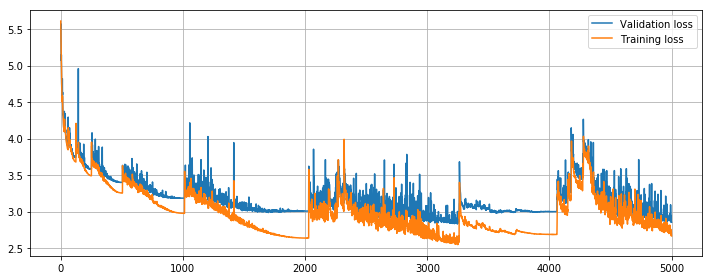

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
plt.plot(autoencoder.history.history['val_loss'], label='Validation loss')
plt.plot(autoencoder.history.history['loss'], label='Training loss')
plt.legend()
plt.grid()
plt.tight_layout()

In [16]:
autoencoder.load_weights(weight_path)

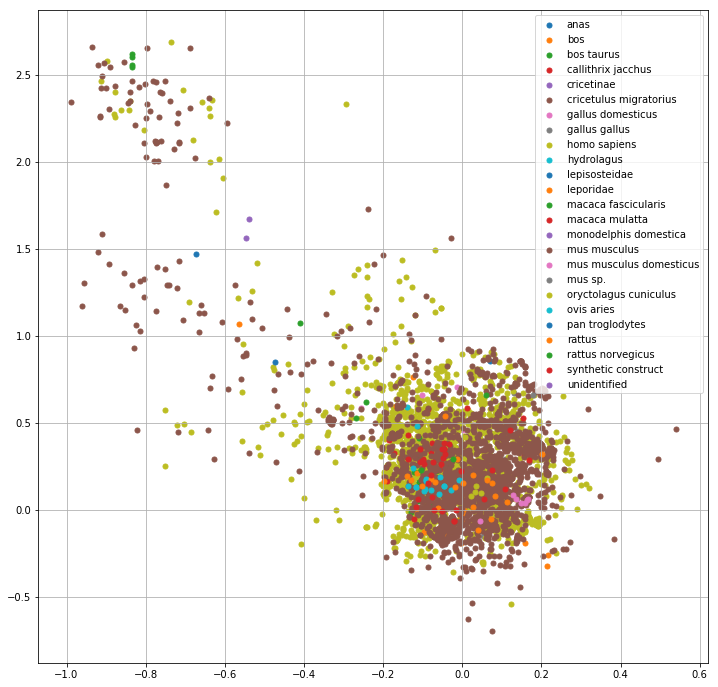

In [17]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

code = encoder.predict([VL_encoded, VH_encoded])

le = LabelEncoder().fit(animals_mask)
labels = le.transform(animals_mask)

unique_labels = np.unique(labels)
len(unique_labels)

c=sns.color_palette(n_colors=25)

f,ax = plt.subplots(figsize=(12,12))
for x in range(unique_labels.size):
    mask_labels = labels == unique_labels[x]
    ax.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', c=c[x],label=le.classes_[x], s=100)
ax.legend()
leg = ax.get_legend()
for i, x in enumerate(leg.legendHandles):
    x.set_color(c[i])
ax.grid()

In [18]:
from abpytools import FabCollection, ChainCollection
import pandas as pd

combinations = pd.read_csv('/home/gil/PhD/UCB/precollection/random_pairs.txt', index_col=0, delimiter=', ')

heavy_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/heavy_chains.json')
light_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/light_chains.json')

heavy_chains_list=[]
light_chains_list=[]

for heavy, light in  combinations['Random Pairs'].str.split('-'):
    heavy_chains_list.append(heavy_chains.get_object(heavy))
    light_chains_list.append(light_chains.get_object(light))    
    
fab_collection = FabCollection(None, heavy_chains_list, light_chains_list,
                               names=['P' + str(x) for x in combinations.index.tolist()])

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

VL_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Light'].values]
VH_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Heavy'].values]

VH_data_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_data)
VL_data_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_data)

code_1 = encoder.predict([VL_data_encoded, VH_data_encoded])

latent_data = pd.DataFrame(code_1, columns=[f"Latent{x}" for x in range(1, 51)], index=fab_collection.names)

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

data.dropna(axis=0, inplace=True, subset=[data.columns[0]])

data = data.join(latent_data)

data.head()

Loading in antibody objects


/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list


,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error,Latent1,Latent2,Latent3,Latent4,Latent5,Latent6,...,Latent41,Latent42,Latent43,Latent44,Latent45,Latent46,Latent47,Latent48,Latent49,Latent50
P2,64.473820,0.000000,NaN,NaN,0.025503,0.469465,-0.175866,0.056807,0.002125,0.025863,...,-0.036016,0.014428,-0.049476,0.068237,-0.028237,-0.065578,-0.107727,-0.002740,0.134621,-0.031895
P3,73.982970,0.130358,NaN,NaN,0.052015,0.445156,-0.351484,0.055841,-0.008783,0.081308,...,-0.056166,0.125430,-0.093496,0.092137,-0.021954,-0.011857,-0.152674,-0.015606,0.205669,-0.049766
P4,64.326010,0.060344,NaN,NaN,-0.156657,0.211694,0.385204,0.064794,-0.154675,0.032971,...,-0.041557,-0.471254,0.018867,-0.015859,-0.015166,-0.118562,-0.111449,0.012579,-0.071607,-0.012525
P6,74.192370,0.036953,NaN,NaN,-0.106716,0.390139,0.084981,-0.056597,-0.023160,0.018120,...,-0.025984,-0.239413,0.083036,-0.017634,0.088104,0.160517,0.086665,0.014772,-0.110802,0.032311
P9,72.899025,0.085337,NaN,NaN,-0.087887,0.092853,0.328381,0.083595,-0.126348,0.035820,...,-0.020854,-0.420445,0.030004,-0.124606,0.072937,0.015532,-0.002602,-0.008645,-0.006449,0.057284


In [19]:
X = data[[x for x in data.columns if 'Latent' in x]].as_matrix()

/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [20]:
norm_variance = [np.var(X[:, x] / abs(np.mean(X[:,x]))) for x in range(X.shape[1])]

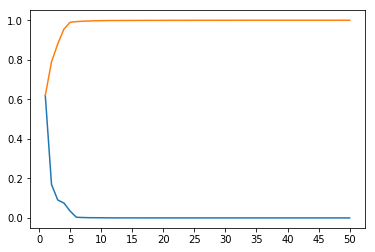

In [21]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=11))

ax.plot(range(1, 51), [norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]])
ax.plot(range(1, 51), np.cumsum([norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]]))

In [22]:
X=X[:, np.argsort(norm_variance)[::-1]][:, :6]

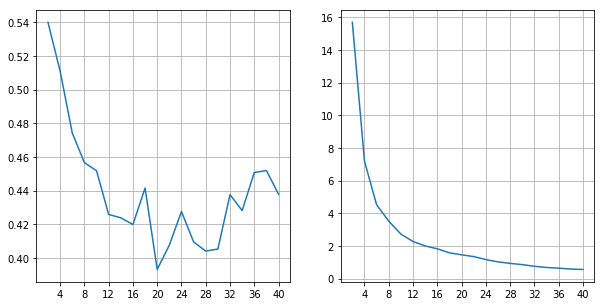

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=11))
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=11))

s_scores = []
i_scores = []
for k in range(2, 41, 2):
    kmeans = KMeans(n_clusters=k, random_state=0)
    s_scores.append(silhouette_score(X, kmeans.fit_predict(X)))
    i_scores.append(kmeans.inertia_)
ax[0].plot(range(2, 41, 2), s_scores)
ax[1].plot(range(2, 41, 2), i_scores)
ax[0].grid()
ax[1].grid()

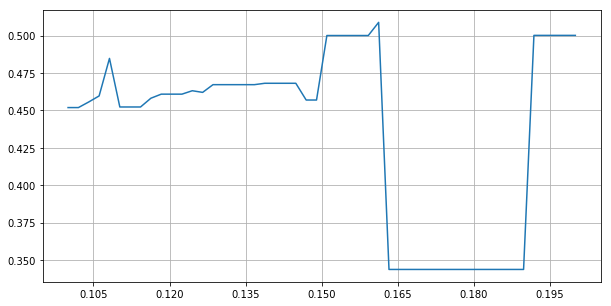

In [54]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
f, ax = plt.subplots(1, 1, figsize=(10,5))
ax.xaxis.set_major_locator(MaxNLocator(nbins=11))

s_scores = []
i_scores = []
for eps in np.linspace(0.1,0.2, 50):
    dbscan = DBSCAN(eps=eps)
    s_scores.append(silhouette_score(X, dbscan.fit_predict(X)))
ax.plot(np.linspace(0.1,0.2, 50), s_scores)
ax.grid()


In [56]:
np.linspace(0.1,0.2, 50)[np.argmax(s_scores)]

0.16122448979591839

In [57]:
EPSILON = np.linspace(0.1,0.2, 50)[np.argmax(s_scores)]

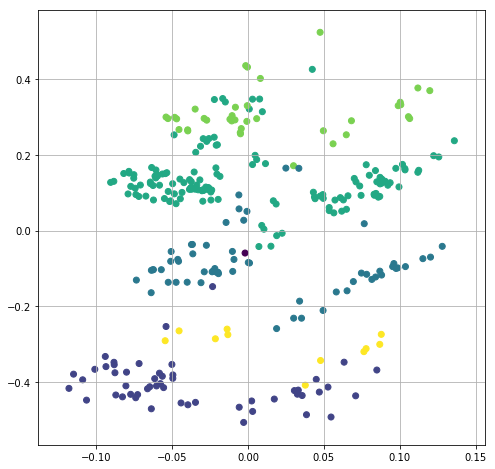

In [60]:
dbscan = DBSCAN(eps=EPSILON)
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=dbscan.fit_predict(X))
plt.grid()

In [64]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4])

In [66]:
dbscan.components_.shape

(295, 6)

In [ ]:
f, ax = plt.subplots(1,2,figsize=(16,8))
kmeans_labels = dbscan.fit_predict(X)
tms = ax[1].scatter(X[:,0], X[:,1], c=data['Tm D - Mean'].values, cmap='RdYlBu_r')
for x in np.unique(dbscan.labels_):
    ax[1].text(kmeans.cluster_centers_[x][0], kmeans.cluster_centers_[x][1],
               'C {}: {:.2f}'.format(x+1, np.median(data.values[kmeans_labels==x, 0])), fontsize=12)
cbar = f.colorbar(tms)
ax[1].grid()
for x in range(N_CLUSTERS):
    sns.distplot(data.values[kmeans_labels==x, 0], ax=ax[0], hist=False, label='Cluster {}'.format(x+1))
ax[0].legend()
ax[0].grid()
#     print(data.values[kmeans_labels==x, 0].mean(), data.values[kmeans_labels==x, 0].std())
plt.tight_layout()

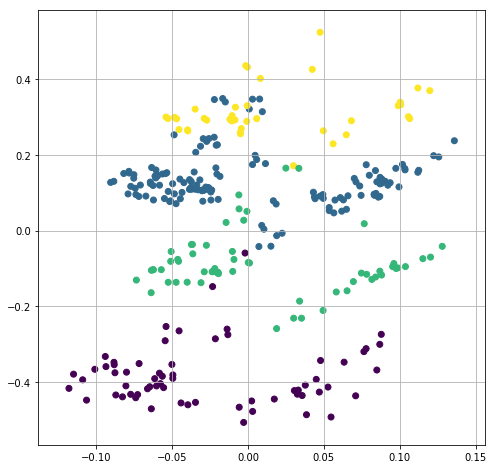

In [25]:
N_CLUSTERS = 4

kmeans = KMeans(N_CLUSTERS, random_state=0)
kmeans.fit(X)
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=kmeans.predict(X))
plt.grid()

/home/gil/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


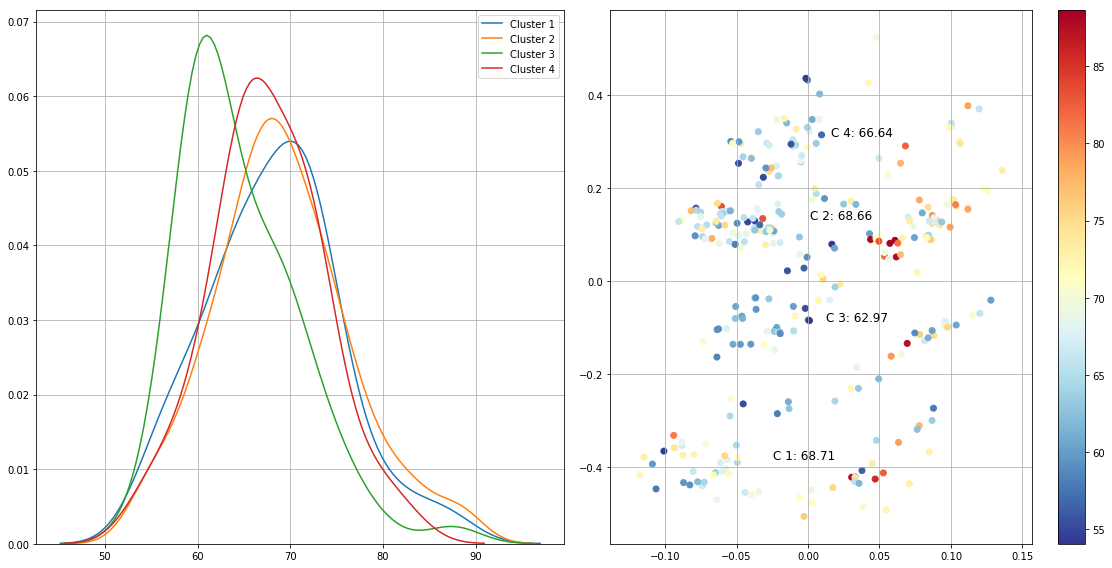

In [26]:
f, ax = plt.subplots(1,2,figsize=(16,8))
kmeans_labels = kmeans.predict(X) 
tms = ax[1].scatter(X[:,0], X[:,1], c=data['Tm D - Mean'].values, cmap='RdYlBu_r')
for x in range(N_CLUSTERS):
    ax[1].text(kmeans.cluster_centers_[x][0], kmeans.cluster_centers_[x][1],
               'C {}: {:.2f}'.format(x+1, np.median(data.values[kmeans_labels==x, 0])), fontsize=12)
cbar = f.colorbar(tms)
ax[1].grid()
for x in range(N_CLUSTERS):
    sns.distplot(data.values[kmeans_labels==x, 0], ax=ax[0], hist=False, label='Cluster {}'.format(x+1))
ax[0].legend()
ax[0].grid()
#     print(data.values[kmeans_labels==x, 0].mean(), data.values[kmeans_labels==x, 0].std())
plt.tight_layout()